### Loading the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the dataset containing information of HYDERABAD cars

In [2]:
df=pd.read_csv('cleaned_hyderabad_cars.csv')
df.head()

,Unnamed: 0,id,car_from,it,ft,bt,km,transmission,ownerNo,owner,...,Turbo Charger,Turning Radius,Tyre Type,Value Configuration,Values per Cylinder,Wheel Base,Wheel Size,Width,d,id.3
0,0,0,hyderabad,0,Petrol,Hatchback,"20,000",Automatic,1,1st Owner,...,Yes,4.9,"Tubeless,Radial",DOHC,4.0,2470mm,R16,1682mm,NaN,0
1,1,1,hyderabad,0,Petrol,Hatchback,"85,582",Manual,2,2nd Owner,...,No,4.6 metres,Tubeless,SOHC,3.0,2380mm,NaN,1550mm,NaN,1
2,2,2,hyderabad,0,Petrol,SUV,"10,000",Manual,1,1st Owner,...,No,NaN,"Tubeless, Radial",NaN,4.0,2500mm,NaN,1770mm,NaN,2
3,3,3,hyderabad,0,Petrol,Hatchback,"50,750",Manual,1,1st Owner,...,No,4.9 meters,"Tubeless,Radial",DOHC,4.0,2520mm,16,1745mm,NaN,3
4,4,4,hyderabad,0,Petrol,SUV,"10,000",Automatic,1,1st Owner,...,Yes,NaN,"Radial, Tubeless",NaN,4.0,2450mm,18,1855mm,NaN,4


In [3]:
df.shape

(1483, 246)

In [4]:
len(df.columns)

246

### Segragating categorical and numerical columns

In [5]:
#categorical columns list
all_cc=[]
#numerical columns list
all_nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        all_cc.append(i)
    else:
        all_nc.append(i)
print('categorical_columns:',all_cc)
print()
print('numerical_columns:',all_nc)

categorical_columns: ['car_from', 'ft', 'bt', 'km', 'transmission', 'owner', 'oem', 'model', 'variantName', 'price', 'priceActual', 'trendingText_heading', 'trendingText_desc', 'Registration Year', 'Insurance Validity', 'Fuel Type', 'Seats', 'Kms Driven', 'RTO', 'Ownership', 'Engine Displacement', 'Transmission', 'Acceleration', 'Alloy Wheel Size', 'BoreX Stroke', 'Cargo Volumn', 'Color', 'Compression Ratio', 'Drive Type', 'Engine', 'Engine Type', 'Front Brake Type', 'Front Tread', 'Fuel Suppy System', 'Gear Box', 'Gross Weight', 'Ground Clearance Unladen', 'Height', 'Kerb Weight', 'Length', 'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Rear Tread', 'Steering Type', 'Super Charger', 'Top Speed', 'Torque', 'Turbo Charger', 'Turning Radius', 'Tyre Type', 'Value Configuration', 'Wheel Base', 'Wheel Size', 'Width']

numerical_columns: ['Unnamed: 0', 'id', 'it', 'ownerNo', 'modelYear', 'centralVariantId', 'priceSaving', 'priceFixedText', 'id.1', 'Year of Manufacture', 'Accessory

In [6]:
# I will use the features in the car_features list along with the features selected using SHAP analysis
car_features=['No Door Numbers', 'No of Cylinder','Values per Cylinder']

### Engineering the 'price' column

In [7]:
x=list(df['price'].apply(lambda x :x.lower()))
am=[]
cu=[]
for i in x:
    try:
        if (i.endswith('e')):
            r=list(i)
            r1=r.index('c')
            am.append(round(float(i[2:r1-1])*10000000,0))
            cu.append(i[r1:])
        elif (i.endswith('h')):
            r=list(i)
            r1=r.index('l')
            am.append(round(float(i[2:r1-1])*100000,0))
            cu.append(i[r1:])
        else:
            d=list(i)
            e=[]
            for j in d:
                if j.isnumeric()==True:
                    e.append(j)
            am.append(float(''.join(e)))
            cu.append('thousand')
    except ValueError:
            am.append(np.nan)
            cu.append(np.nan)

In [8]:
#New price column - this will be the 'target' variable
df['price_new']=am

In [9]:
#Lets take a look at the original and preprocessed price columns
df[['price','price_new']].head()

,price,price_new
0,₹ 10.44 Lakh,1044000.0
1,₹ 2.60 Lakh,260000.0
2,₹ 9.55 Lakh,955000.0
3,₹ 6.71 Lakh,671000.0
4,₹ 19 Lakh,1900000.0


### Engineering the 'km' column

In [10]:
kms=[]
for i in list(df['km']):
    d=list(i)
    e=[]
    for j in d:
        if j.isnumeric()==True:
            e.append(j)
    kms.append(float(''.join(e)))
    

In [11]:
#new km column
df['kms']=kms

In [12]:
df[['kms','km','Kms Driven']]

,kms,km,Kms Driven
0,20000.0,"20,000","20,000 Kms"
1,85582.0,"85,582","85,582 Kms"
2,10000.0,"10,000","10,000 Kms"
3,50750.0,"50,750","50,750 Kms"
4,10000.0,"10,000","10,000 Kms"
...,...,...,...
1478,60000.0,"60,000","60,000 Kms"
1479,50000.0,"50,000","50,000 Kms"
1480,120000.0,"1,20,000","1,20,000 Kms"
1481,50000.0,"50,000","50,000 Kms"


### Combining the selected features in the list 'all_selected_features'

In [13]:
all_selected_features=['bt','owner', 'oem','Registration Year','Engine Displacement',
      'Seating Capacity','Alloy Wheel Size','Turbo Charger', 'Engine',  'Front Brake Type',
 'Gear Box', 'Height', 'Kerb Weight', 'Length', 'Max Power', 
'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base','Width','kms','price_new']
for i in car_features:
    all_selected_features.append(i)

In [14]:
df=df[all_selected_features]
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,Max Torque,Mileage,Rear Brake Type,Wheel Base,Width,kms,price_new,No Door Numbers,No of Cylinder,Values per Cylinder
0,Hatchback,1st Owner,Volkswagen,2022,999 cc,5,R16,Yes,999 CC,Disc,...,175nm@1750-4000rpm,16.47 kmpl,Drum,2470mm,1682mm,20000.0,1044000.0,5,3.0,4.0
1,Hatchback,2nd Owner,Hyundai,Oct 2014,814 cc,5,NaN,No,814 CC,Disc,...,74.5Nm@4000rpm,21.1 kmpl,Drum,2380mm,1550mm,85582.0,260000.0,5,3.0,3.0
2,SUV,1st Owner,Hyundai,2023,Manual,5,NaN,No,1197 CC,Disc,...,113.8Nm@4000rpm,NaN,Drum,2500mm,1770mm,10000.0,955000.0,5,4.0,4.0
3,Hatchback,1st Owner,Maruti,Mar 2017,1197 cc,5,16,No,1197 CC,Disc,...,115Nm@4000rpm,21.4 kmpl,Drum,2520mm,1745mm,50750.0,671000.0,5,4.0,4.0
4,SUV,1st Owner,Mahindra,2022,Automatic,4,18,Yes,1997 CC,Disc,...,320Nm@1500-3000rpm,NaN,Drum,2450mm,1855mm,10000.0,1900000.0,3,4.0,4.0


In [15]:
df_nv=pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})
df_nv

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,2,7,0.001349
owner,object,0,5,0.000000
oem,object,0,26,0.000000
Registration Year,object,0,189,0.000000
Engine Displacement,object,3,93,0.002023
Seating Capacity,int64,0,8,0.000000
Alloy Wheel Size,object,570,16,0.384356
Turbo Charger,object,217,6,0.146325
Engine,object,1,97,0.000674
Front Brake Type,object,13,19,0.008766


**I will impute the columns having more than 30% missing values and drop null rows having less 3% missing values**

### Engineering the 'bt' column and renaming the new column as 'body_type'

In [16]:
df['body_type']=df['bt'].apply(lambda x:str(x).lower())
df['body_type'].value_counts()

body_type
hatchback        683
sedan            376
suv              350
muv               66
minivans           3
nan                2
pickup trucks      2
coupe              1
Name: count, dtype: int64

In [17]:
df['body_type']=['other' if i=='muv' or i=='minivans' or i=='hybrids' or i=='coupe'  else i for i in list(df['body_type'])]
df['body_type'].value_counts()

body_type
hatchback        683
sedan            376
suv              350
other             70
nan                2
pickup trucks      2
Name: count, dtype: int64

### Engineering the 'owner' column 

In [18]:
df['owner']=df['owner'].apply(lambda x:x.lower())
df['owner'].value_counts()

owner
1st owner    1037
2nd owner     394
3rd owner      49
5th owner       2
4th owner       1
Name: count, dtype: int64

In [19]:
df['owner']=df['owner'].map({'0th owner':'no_owner','1st owner':'1_owner','2nd owner':'2_owners','3rd owner':'>2_owners','4th owner':'>2_owners','5th owner':'>2_owners'})
df['owner'].value_counts()

owner
1_owner      1037
2_owners      394
>2_owners      52
Name: count, dtype: int64

### Engineering the 'oem' column 

In [20]:
df['oem']=df['oem'].apply(lambda x:x.lower())
df['oem'].value_counts()

oem
maruti                440
hyundai               308
honda                 127
tata                   93
mahindra               63
volkswagen             58
ford                   54
renault                54
toyota                 45
skoda                  30
mercedes-benz          25
datsun                 24
bmw                    21
nissan                 20
jeep                   19
mg                     18
kia                    17
audi                   17
chevrolet              16
volvo                  11
jaguar                 10
fiat                    6
land rover              4
citroen                 1
hindustan motors        1
mahindra ssangyong      1
Name: count, dtype: int64

In [21]:
car_make=['mg','nissan','jeep','chevrolet','volvo','fiat','land rover','mitsubishi','mini','jaguar','isuzu','citroen',
          'mahindra renault','mahindra ssangyong','lexus']
df['oem']=['other' if i in car_make  else i for i in list(df['oem'])]
df['oem'].value_counts()

oem
maruti              440
hyundai             308
honda               127
other               106
tata                 93
mahindra             63
volkswagen           58
renault              54
ford                 54
toyota               45
skoda                30
mercedes-benz        25
datsun               24
bmw                  21
kia                  17
audi                 17
hindustan motors      1
Name: count, dtype: int64

### Engineering the 'Registration Year' column 

In [22]:
df['registration_year']=df['Registration Year'].apply(lambda x:str(x).lower())
df['registration_year'].value_counts()[:10]

registration_year
2022    55
2018    46
2021    36
2016    33
2019    33
2020    30
2017    30
2015    27
2013    26
2011    26
Name: count, dtype: int64

In [23]:
df['registration_year']=df['Registration Year'].apply(lambda x:x[-4:])
df['registration_year'].value_counts()

registration_year
2018    213
2017    162
2019    152
2021    126
2016    122
2020    109
2022     95
2014     88
2015     84
2013     82
2012     70
2011     54
2010     31
2008     20
2009     19
2023     15
2006      9
2007      9
2004      8
ance      6
2003      5
2002      2
2005      2
Name: count, dtype: int64

In [24]:
ry=['2007','2006','2005','2004','2003','2002',]
df['registration_year']=['before_2008' if i in ry  else i for i in list(df['registration_year'])]
df['registration_year']=['not_specified' if i=='ance' else i for i in list(df['registration_year'])]
df['registration_year'].value_counts()

registration_year
2018             213
2017             162
2019             152
2021             126
2016             122
2020             109
2022              95
2014              88
2015              84
2013              82
2012              70
2011              54
before_2008       35
2010              31
2008              20
2009              19
2023              15
not_specified      6
Name: count, dtype: int64

### Engineering the 'Seating Capacity' column 

In [25]:
df['seating_capacity']=df['Seating Capacity'].apply(lambda x:str(x))
df['seating_capacity'].value_counts()

seating_capacity
5     1334
7      104
6       19
8       13
4        9
2        2
9        1
10       1
Name: count, dtype: int64

In [26]:
df['seating_capacity']=df['seating_capacity'].map({'4':'4','5':'5','6':'6',
                                                      '7':'7',
                                                      '8':'>=8','9':'>=8','10':'>=8'})
df['seating_capacity'].value_counts()

seating_capacity
5      1334
7       104
6        19
>=8      15
4         9
Name: count, dtype: int64

In [27]:
df.fillna({'seating_capacity':'5'},inplace=True)

### Engineering the 'Engine Displacement' column 

In [28]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
df['engine_displacement'].value_counts()[:50]

engine_displacement
1197 cc      277
998 cc       113
1248 cc      105
manual        87
999 cc        79
1497 cc       76
1498 cc       65
1199 cc       59
796 cc        41
1198 cc       41
1086 cc       36
2179 cc       34
automatic     33
1582 cc       33
1462 cc       28
1956 cc       26
1968 cc       19
1493 cc       18
1396 cc       18
1591 cc       17
1995 cc       17
1598 cc       15
799 cc        13
1461 cc       13
1368 cc       11
1496 cc        9
2494 cc        9
2143 cc        8
1120 cc        8
1997 cc        8
1186 cc        7
814 cc         7
1196 cc        7
1373 cc        7
1999 cc        6
1399 cc        6
2755 cc        6
1451 cc        6
2993 cc        5
1984 cc        5
0 cc           5
1499 cc        4
1194 cc        4
2393 cc        4
1405 cc        3
1896 cc        3
nan            3
1798 cc        3
1799 cc        3
2198 cc        3
Name: count, dtype: int64

In [29]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
ed=[]
for i in list(df['engine_displacement']):
    d=list(i)
    e=[]
    if i=='nan':
        ed.append(np.nan)
    elif i=='automatic':
        ed.append(9)
    elif i=='manual':
        ed.append(6)
    else:
        for j in d:
            if j.isnumeric()==True:
                e.append(j)

        
        ed.append(float(''.join(e)))
        
print(len(ed))    
df['engine_displacement']=ed
print(df['engine_displacement'].value_counts().sort_values())
print(set(ed))

1483
engine_displacement
1796.0      1
1599.0      1
1341.0      1
2956.0      1
2496.0      1
         ... 
999.0      79
6.0        87
1248.0    105
998.0     113
1197.0    277
Name: count, Length: 93, dtype: int64
{nan, 0.0, 6, 9, 1047.0, 1061.0, 1582.0, 2609.0, 1591.0, 1595.0, 1596.0, 1597.0, 1598.0, 1086.0, 1599.0, 2143.0, 1120.0, 2148.0, 2157.0, 3198.0, 2179.0, 2696.0, 1172.0, 2198.0, 1186.0, 1193.0, 1194.0, 1196.0, 1197.0, 1198.0, 1199.0, 2231.0, 2755.0, 1248.0, 1781.0, 1794.0, 1796.0, 1798.0, 1799.0, 1298.0, 796.0, 799.0, 814.0, 1330.0, 2354.0, 1332.0, 2359.0, 1341.0, 1349.0, 1353.0, 1364.0, 1368.0, 2393.0, 1373.0, 2400.0, 1896.0, 1390.0, 1396.0, 1399.0, 1405.0, 2956.0, 2446.0, 1950.0, 1956.0, 2982.0, 936.0, 1451.0, 2987.0, 1968.0, 2993.0, 1969.0, 2995.0, 2996.0, 1461.0, 1462.0, 2494.0, 1984.0, 1985.0, 2498.0, 2496.0, 1991.0, 1995.0, 1996.0, 1997.0, 1999.0, 1493.0, 1496.0, 1497.0, 1498.0, 1499.0, 2523.0, 995.0, 998.0, 999.0}


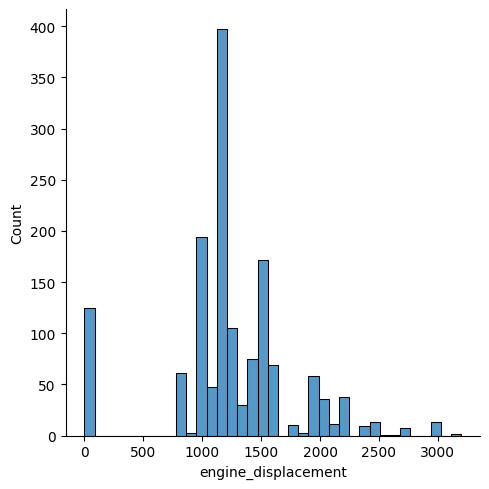

mean: 1255.747972972973 median: 1198.0


In [30]:
sns.displot(df['engine_displacement'])
plt.show()
print('mean:',df['engine_displacement'].mean(),'median:',df['engine_displacement'].median())

In [31]:
df.fillna({'engine_displacement':df['engine_displacement'].median()},inplace=True)

### Engineering the 'Alloy Wheel Size' column 

In [32]:
df['alloy_wheel_size']=df['Alloy Wheel Size'].apply(lambda x:str(x).lower())
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
nan    570
16     286
15     181
17     125
14     123
13      62
18      38
r16     23
r15     21
r17     13
12      12
20      10
19       9
r18      7
r14      1
21       1
r19      1
Name: count, dtype: int64

In [33]:
al=[]
for i in list(df['alloy_wheel_size']):
    if i=='nan':
        al.append(np.nan)
    elif i[0]!='r':
        al.append(f'r{i}')
    else:
        al.append(i)
df['alloy_wheel_size']=al
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
r16    309
r15    202
r17    138
r14    124
r13     62
r18     45
r12     12
r19     10
r20     10
r21      1
Name: count, dtype: int64

In [34]:
df.fillna({'alloy_wheel_size':'r16'},inplace=True)

In [35]:
df['alloy_wheel_size'].isnull().sum()

0

### Engineering the 'Turbo Charger' column

In [36]:
df['turbo_charger']=df['Turbo Charger'].apply(lambda x:str(x).lower())
print(df['turbo_charger'].value_counts())

turbo_charger
no      697
yes     566
nan     217
twin      3
Name: count, dtype: int64


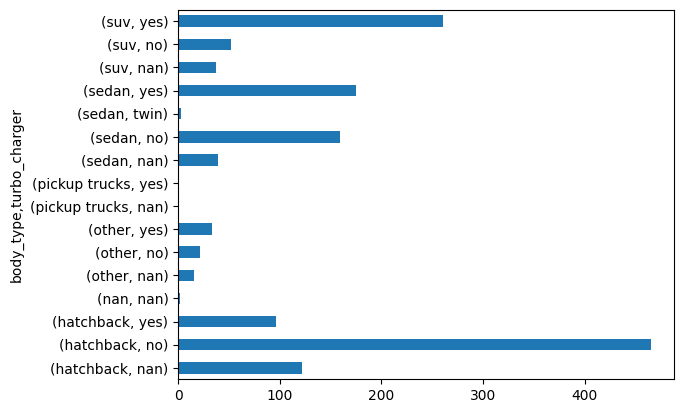

In [37]:
df.groupby(['body_type','turbo_charger'])['turbo_charger'].count().plot(kind='barh')
plt.show()

In [38]:
z=list(df[df['turbo_charger']=='nan']['body_type'])
z

['hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'sedan',
 'suv',
 'hatchback',
 'suv',
 'suv',
 'sedan',
 'hatchback',
 'sedan',
 'other',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'suv',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'other',
 'sedan',
 'sedan',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'hatchback',
 'other',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'sedan',
 'sedan',
 'suv',
 'other',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'suv',
 'hatchback',
 'other',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'other',
 'sedan',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'sedan',
 'suv',
 'sedan',
 'suv',


In [39]:
for h in range(len(z)):
    if z[h]=='suv' or z[h]=='other':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='yes'
    elif z[h]=='hatchback' or z[h]=='sedan':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='no'

In [40]:
df['turbo_charger'].isnull().sum()

0

### Engineering the 'Front Brake Type' column

In [41]:
df.columns

Index(['bt', 'owner', 'oem', 'Registration Year', 'Engine Displacement',
       'Seating Capacity', 'Alloy Wheel Size', 'Turbo Charger', 'Engine',
       'Front Brake Type', 'Gear Box', 'Height', 'Kerb Weight', 'Length',
       'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base',
       'Width', 'kms', 'price_new', 'No Door Numbers', 'No of Cylinder',
       'Values per Cylinder', 'body_type', 'registration_year',
       'seating_capacity', 'engine_displacement', 'alloy_wheel_size',
       'turbo_charger'],
      dtype='object')

In [42]:
df['front_brake_type']=df['Front Brake Type'].apply(lambda x:str(x).lower())
print(df['front_brake_type'].value_counts())

front_brake_type
disc                      966
ventilated disc           437
disc                       19
nan                        13
ventilated discs           12
disc & caliper type         9
solid disc                  8
ventilated disc             6
disk                        3
ventillated disc            2
vantilated disc             2
ventlated disc              2
electric parking brake      1
 disc                       1
 ventilated disc            1
disc, 236 mm                1
Name: count, dtype: int64


In [43]:
df['front_brake_type'].unique()

array(['disc', 'ventilated disc', 'ventilated discs',
       'disc & caliper type', 'disk', 'solid disc', 'disc ', 'nan',
       'ventilated disc ', 'electric parking brake', 'ventillated disc',
       'vantilated disc', ' disc', ' ventilated disc', 'ventlated disc',
       'disc, 236 mm'], dtype=object)

In [44]:
df['front_brake_type']=df['front_brake_type'].map({'disc':'solid disc','ventilated disc':'ventilated discs',
                                                   'ventilated discs':'ventilated discs','disc ':'solid disc',
                                                   'solid disc':'solid disc','disk':'solid disc','ventilated disk':'ventilated discs',
                                                   'ventilated disc ':'ventilated discs','vantilated disc':'ventilated discs',
                                                   'ventlated disc':'ventilated discs','disc, 236 mm':'solid disc','nan':'solid disc',
                                                   'drum':'other','multilateral disc':'other','disc & caliper type':'other',
                                                   'booster assisted ventilated disc':'other','caliper ventilated disc':'other',
                                                   'abs':'other'})
print(df['front_brake_type'].value_counts())

front_brake_type
solid disc          1010
ventilated discs     459
other                  9
Name: count, dtype: int64


### Engineering the 'Gear Box' column

In [45]:
df['gear_box']=df['Gear Box'].apply(lambda x:str(x).lower())
print(df['gear_box'].value_counts())

gear_box
5 speed                                     836
6 speed                                     184
5-speed                                     122
6-speed                                      52
7 speed                                      33
5 speed                                      32
8 speed                                      32
4 speed                                      25
6 speed                                      24
cvt                                          24
nan                                          17
5                                            14
9 speed                                      10
6-speed imt                                   7
5 speed cvt                                   6
8-speed                                       6
ags                                           5
4 speed                                       4
7 speed dct                                   4
4-speed                                       3
7-speed dsg                    

In [46]:
df['gear_box'].unique()

array(['6 speed', '5 speed', '5-speed', '6-speed imt', '7 speed dct',
       '5 speed ', '8 speed', '6 speed imt', '6-speed', '9 speed',
       '6 speed ', '6-speed at', '6-speed ivt', '8-speed steptronic',
       '7-speed dsg', '4 speed', '7 speed', '5', '6 speed ivt',
       '7-speed s-tronic ', 'nan', 'cvt', '8-speed ', 'ags', '8-speed',
       'imt', '6 speed automatic', '7g-dct', '7 speed dsg', '6',
       '5 speed cvt', 'six speed geartronic, six speed automati',
       '7 speed cvt', '5 speed manual (cable type gear shift)',
       '4 speed ', '4-speed', 'six speed automatic gearbox', '7-speed',
       '10 speed', '7-speed dct', '6-speed cvt', 'fully automatic',
       'single-speed transmission', 'six speed  gearbox',
       '5 speed forward, 1 reverse',
       '7g dct 7-speed dual clutch transmission ', '7 speed s tronic',
       '6-speed dct'], dtype=object)

In [47]:
gb=[]
for i in list(df['gear_box']):
    if i=='5 speed' or i=='5-speed' or i=='5 speed ' or i=='5' or i=='five speed' :
        gb.append('5 speed')
    elif i=='five speed manual transmission gearbox' :
        gb.append('5 speed manual transmission')
    elif i=='five speed manual transmission':
        gb.append('5 speed manual transmission')
    elif i in ['7 speed ','7-speed']:
        gb.append('7 speed')
    elif i in ['7-speed stronic','7-speed s-tronic','7-speed s-tronic ']:
        gb.append('7-speed s-tronic')
    elif i in [ '7 speed dct','7-speed dct']:
        gb.append( '7 speed dct')
    elif i in ['8-speed','8', '8-speed ','8 speed ']:
        gb.append('8 speed')
    elif i in ['6 speed ','6-speed','6']:
        gb.append('6 speed')
    elif i in ['6-speed at','6-speed at' ,'6 speed at',]:
        gb.append('6-speed at')
    elif i in ['six speed manual',]:
        gb.append('6-speed manual') 
    else:
        gb.append(i)
        

In [48]:
df['gear_box']=gb
print(df['gear_box'].value_counts())

gear_box
5 speed                                     1004
6 speed                                      261
8 speed                                       40
7 speed                                       35
4 speed                                       25
cvt                                           24
nan                                           17
9 speed                                       10
6-speed imt                                    7
7 speed dct                                    6
5 speed cvt                                    6
ags                                            5
4 speed                                        4
4-speed                                        3
7-speed s-tronic                               3
7-speed dsg                                    3
8-speed steptronic                             3
10 speed                                       2
imt                                            2
7 speed dsg                                    2
7 speed cvt

In [49]:
x=list(df['gear_box'])
gb1=['other' if x.count(i)<10 else i for i in x ]

In [50]:
df['gear_box']=gb1
print(df['gear_box'].value_counts())

gear_box
5 speed    1004
6 speed     261
other        67
8 speed      40
7 speed      35
4 speed      25
cvt          24
nan          17
9 speed      10
Name: count, dtype: int64


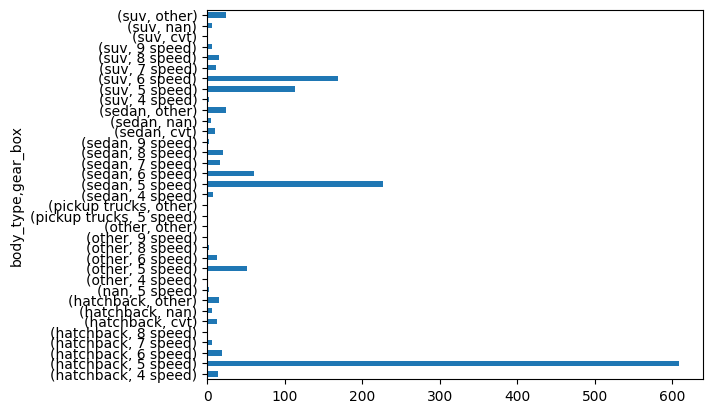

In [51]:
df.groupby(['body_type','gear_box'])['gear_box'].count().plot(kind='barh')
plt.show()

In [52]:
df.fillna({'gear_box':'5 speed'},inplace=True)

In [53]:
df['gear_box'].isnull().sum()

0

### Engineering the 'Mileage' column

In [54]:
df['mileage']=df['Mileage'].apply(lambda x:str(x).lower())
print(df['mileage'].value_counts())

mileage
18.9 kmpl     52
18.6 kmpl     46
nan           42
21.4 kmpl     42
22.38 kmpl    30
              ..
17.11 kmpl     1
16.4 kmpl      1
20.58 kmpl     1
17.97 kmpl     1
18.07 kmpl     1
Name: count, Length: 325, dtype: int64


In [55]:
avs=[]
for i in list(df['mileage']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['mileage']=avs
df['mileage'].value_counts()

mileage
19.0    191
21.0    162
22.0    145
17.0    145
20.0    144
18.0    128
23.0     91
24.0     79
16.0     78
25.0     49
15.0     49
13.0     39
14.0     36
28.0     23
26.0     21
27.0     20
12.0     18
11.0      9
10.0      5
9.0       2
36.0      2
31.0      1
8.0       1
34.0      1
33.0      1
30.0      1
Name: count, dtype: int64

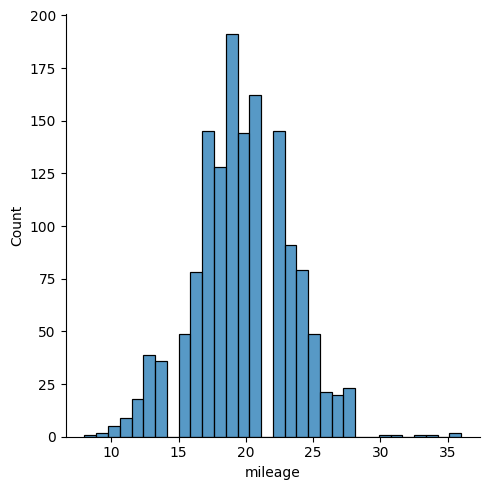

mean: 19.70784177654407 median: 20.0


In [56]:
sns.displot(df['mileage'])
plt.show()
print('mean:',df['mileage'].mean(),'median:',df['mileage'].median())

In [57]:
df.fillna({'mileage':df['mileage'].median()},inplace=True)

In [58]:
df['mileage'].isnull().sum()

0

### Engineering the 'Wheel Base' column

In [59]:
df['wheel_base' ]=df['Wheel Base' ].apply(lambda x:str(x).lower())
print(df['wheel_base' ].value_counts())

wheel_base
2425mm     77
2520mm     74
2570mm     71
2450       65
2600mm     65
           ..
2960mm      1
2920mm      1
2776 mm     1
2647mm      1
2864mm      1
Name: count, Length: 160, dtype: int64


In [60]:
avs=[]
for i in list(df['wheel_base']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['wheel_base']=avs
df['wheel_base'].value_counts()

wheel_base
2450.0    126
2520.0     85
2600.0     82
2425.0     78
2380.0     77
         ... 
3120.0      1
2729.0      1
2819.0      1
2933.0      1
2864.0      1
Name: count, Length: 115, dtype: int64

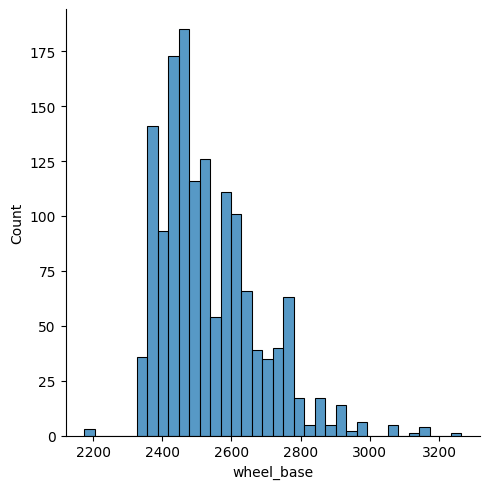

mean: 2533.867032213845 median: 2500.0


In [61]:
sns.displot(df['wheel_base'])
plt.show()
print('mean:',df['wheel_base'].mean(),'median:',df['wheel_base'].median())

In [62]:
df.fillna({'wheel_base':df['wheel_base'].median()},inplace=True)

In [63]:
df['wheel_base'].isnull().sum()

0

### Engineering the 'Height' column

In [64]:
df['height' ]=df['Height'].apply(lambda x:str(x).lower())
print(df['height'].value_counts())

height
1505mm    73
1510mm    61
1520mm    57
1475mm    56
1495mm    46
          ..
1642mm     1
1784mm     1
1421mm     1
1680mm     1
1676mm     1
Name: count, Length: 208, dtype: int64


In [65]:
avs=[]
for i in list(df['height']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['height']=avs
df['height'].value_counts()

height
1530.0    83
1505.0    79
1520.0    78
1475.0    73
1510.0    61
          ..
1875.0     1
1780.0     1
1420.0     1
1776.0     1
1676.0     1
Name: count, Length: 158, dtype: int64

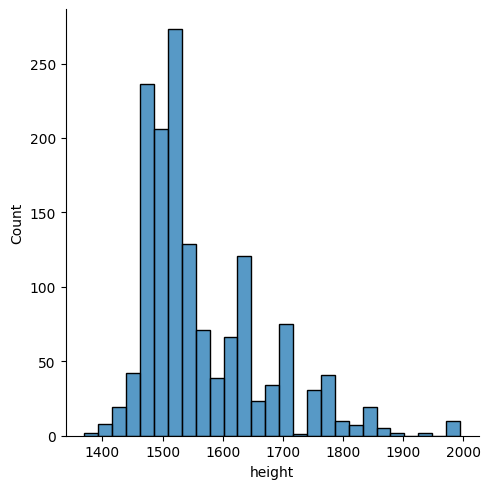

mean: 1566.9599184782608 median: 1530.0


In [66]:
sns.displot(df['height'])
plt.show()
print('mean:',df['height'].mean(),'median:',df['height'].median())

In [67]:
df.fillna({'height':df['height'].median()},inplace=True)

### Engineering the 'Kerb Weight' column

In [68]:
df['kerb_weight' ]=df['Kerb Weight'].apply(lambda x:str(x).lower())
print(df['kerb_weight'].value_counts())
df['kerb_weight'].unique()

kerb_weight
875-905    38
1066kg     28
755        26
935kg      24
885kg      24
           ..
1125kg      1
845         1
1651kg      1
2160        1
1700kg      1
Name: count, Length: 451, dtype: int64


array(['1106', '880', '890kg', '1825', '1232', '850kg', '1260',
       '1016-1033kg', '1012kg', '750', '765', '1125kg', '870kg', '1550',
       '805-825kg', '1562 kgs', '1641 kgs', '1220', '1110', '1240',
       '1120', '1860', '736-775', '1475', '860-895kg', '755', '1242kg',
       '1044kg', '1066kg', '2150kg', '1879kg', '875-905', '1815', '1030',
       '1027kg', '710', '865-890', '1090kg', '860kg', '945kg', '1840',
       '1235kg', '1111kg', '1210kg', '1025', '880-915', '925', '965kg',
       '762kg', '1060', '835', '1016-1026kg', '1640', '886kg', '1050',
       '1,575', '1030kg', '1095kg', '1210 kg.', 'nan', '1515kg', '1630',
       '1555', '880kg', '1660', '1100', '855', '1115-1130', '960kg',
       '1880', '825kg', '1155 kg', '1150 - 1185', '1312', '1940', '1200',
       '730', '830-845kg', '1105', '1061', '990', '1020', '770', '1652kg',
       '1,130 kg', '705kg', '1650 kgs', '720kg', '1182kg', '1069kg',
       '960kgs', '825', '930', '1060kg', '1950', '1180kg', '1655kg',
      

In [69]:
avs=[]
for i in list(df['kerb_weight']):
    if i=='nan' or i=='kerb weight':
        avs.append(np.nan)
    
    elif i[0].isnumeric()==True:
        
        b=[]
        if '-' in list(i):
            r=i.index('-')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['kerb_weight']=avs
df['kerb_weight'].value_counts()

kerb_weight
875.0     39
1100.0    33
880.0     30
1066.0    28
755.0     26
          ..
690.0      1
1766.0     1
1745.0     1
1405.0     1
1420.0     1
Name: count, Length: 326, dtype: int64

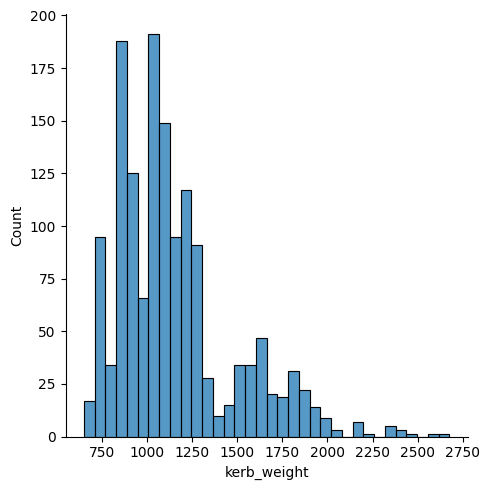

mean: 1153.4168363883232 median: 1085.0


In [70]:
sns.displot(df['kerb_weight'])
plt.show()
print('mean:',df['kerb_weight'].mean(),'median:',df['kerb_weight'].median())

In [71]:
df.fillna({'kerb_weight':df['kerb_weight'].median()},inplace=True)

### Engineering the 'Length' column

In [72]:
df['length' ]=df['Length'].apply(lambda x:str(x).lower())
print(df['length'].value_counts())
df['length'].unique()

length
3995mm    198
4440mm     58
3765mm     51
3985mm     51
3845mm     38
         ... 
4456        1
4291mm      1
4324mm      1
4575mm      1
4708mm      1
Name: count, Length: 227, dtype: int64


array(['3971mm', '3495mm', '3995mm', '3985mm', '3695mm', '4440mm',
       '3715mm', '3941 mm', '3746mm', '3435mm', '3731mm', '3970mm',
       '3595mm', '4439mm', '3655 mm', '4395mm', '4315mm', '3765mm',
       '4720mm', '3565mm', '3565', '3445', '3998mm', '3955mm', '4819mm',
       '4892mm', '3845mm', '3990mm', '4425mm', '4585mm', '4456mm',
       '4265mm', '4413mm', '4490 mm', '3700mm', '3840mm', '3445mm',
       '3805mm', '4627mm', '3788mm', '3610 mm', '4907mm', '3989mm',
       '4413 mm', '4329mm', '4540mm', '4936mm', '4300mm', '3995',
       '4699mm', '4662mm', '4420 mm', '4345mm', '4221mm', '3679mm',
       '3585mm', '3775mm', '3640mm', '4440', '3940 mm', '4490mm',
       '4635mm', '4,282 mm', '4585 mm', '3430mm', '4386mm', '3850mm',
       '4375mm', '4788mm', '4445mm', '4686mm', '4384 mm', '4270mm',
       '4385mm', '3530mm', '4655mm', '4430mm', '3600mm', '5063mm',
       '3895mm', '4549mm', '4850 mm', 'nan', '5130mm', '3429mm', '4629mm',
       '3610mm', '4596mm', '3884mm', '463

In [73]:
avs=[]
for i in list(df['length']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['length']=avs
df['length'].value_counts()

length
3995.0    221
4440.0     60
3765.0     51
3985.0     51
3845.0     38
         ... 
4633.0      1
5200.0      1
4291.0      1
4324.0      1
4708.0      1
Name: count, Length: 200, dtype: int64

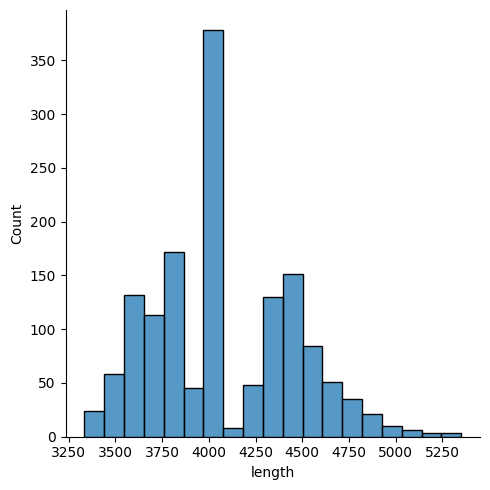

mean: 4073.514945652174 median: 3995.0


In [74]:
sns.displot(df['length'])
plt.show()
print('mean:',df['length'].mean(),'median:',df['length'].median())

In [75]:
df.fillna({'length':df['length'].median()},inplace=True)

### Engineering the 'Max Power' column

In [76]:
df['max_power']=df['Max Power'].apply(lambda x:str(x).lower())
print(df['max_power'].value_counts())
df['max_power'].unique()

max_power
88.50bhp     66
81.86bhp     48
81.80bhp     46
74bhp        45
83.1bhp      42
             ..
163.60bhp     1
138.05bhp     1
57.6bhp       1
241.6bhp      1
144           1
Name: count, Length: 265, dtype: int64


array(['108.62bhp', '55.2bhp', '81.80bhp', '83.1bhp', '150bhp',
       '118.36bhp', '67.04bhp', '118.41bhp', '94.93bhp', '83.83bhp',
       '67.05bhp', '67bhp', '73.9bhp', '188bhp', '170bhp', '170.63bhp',
       '81.86bhp', '83.8bhp', '167.67bhp', '65.71bhp', '113.43bhp',
       '47.33bhp', '121.31bhp', '88.7bhp', '81.83bhp', '201.15bhp',
       '197.2bhp', '88.50bhp', '86.83bhp', '75bhp', '53.26bhp',
       '105.94bhp', '83.14bhp', '140bhp', '117.3bhp', '88.8bhp',
       '103.2bhp', '88.5bhp', '103.25bhp', '77bhp', '74bhp', '163bhp',
       '68bhp', '190bhp', '67.1bhp', '90 ps', '108.45bhp', '88.73bhp',
       '114.41bhp', '113.42bhp', '187.74bhp', '113.18bhp', '103.26bhp',
       '141bhp', '200bhp', '118ps at 6,600 rpm', '101.64bhp', '147.51bhp',
       '68.05bhp', '85.80bhp', '56.3bhp', '117.60bhp',
       '80 ps at 5200 rpm', '53.64bhp', '91.1bhp', '181bhp', '101 ',
       '46.3bhp', '121bhp', '47.3bhp', '73.97bhp', '103.52bhp',
       '73.75bhp', '78.9bhp', '121.3bhp', '153.86bhp'

In [77]:
a=[]
for i in list(df['max_power']):
    if 'bhp' not in i:
        a.append(i)
print(set(a))

{'210', '165 [224] at 3800', '102', '82  ps ', '144 ', '85', '118ps at 6,600 rpm', '140ps ', '103.2 ', '101 ', '110(150)/5700', '174.33', 'nan', '110 ', '57.5', '63 ', '116.6 ', '92', '60 ps ', '165 ', '178 ', '104  ps ', '171 ps ', '90 ps', '66(90) / 4000', '68 ', '100 ', '163.2', '78 ', '80 ps at 5200 rpm', '105ps ', '82.9 ', '70', '170 ', '75 ps ', '125'}


In [78]:
avs=[]
for i in list(df['max_power']):
    if i=='nan':
        avs.append(np.nan)
    elif i=='66(90) / 4000' or i=='90(66) ':
        avs.append(65)
    elif i=='118ps at 6,600 rpm':
        avs.append(116.39)
    elif i=='105 ps at 5250 rpm':
        avs.append(103.56)
    elif i=='90ps at 4000rpm':
        avs.append(78.91)
    elif i=='80 ps at 5200 rpm':
        avs.append(99.77)
    elif i=='63 hp at 3200 rpm':
        avs.append(63)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['max_power']=avs
df['max_power'].value_counts()

max_power
82.0     141
67.0     118
88.0      98
74.0      76
103.0     53
        ... 
136.0      1
203.0      1
96.0       1
157.0      1
144.0      1
Name: count, Length: 123, dtype: int64

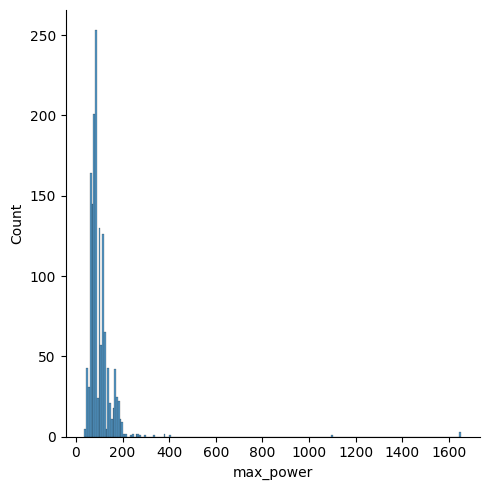

mean: 103.31492527173914 median: 88.0


In [79]:
sns.displot(df['max_power'])
plt.show()
print('mean:',df['max_power'].mean(),'median:',df['max_power'].median())

In [80]:
df.fillna({'max_power':df['max_power'].median()},inplace=True)

### Engineering the 'Max Torque' column

In [81]:
df['max_torque' ]=df['Max Torque'].apply(lambda x:str(x).lower())
print(df['max_torque' ].value_counts())
df['max_torque' ].unique()

max_torque
90nm@3500rpm            68
200nm@1750rpm           61
113nm@4400rpm           58
190nm@2000rpm           57
115nm@4000rpm           43
                        ..
520nm@2000-4200rpm       1
440nm@1500rpm            1
250nm@1250-5000rpm       1
254nm@1600rpm            1
20 @ 4,700 (kgm@rpm)     1
Name: count, Length: 277, dtype: int64


array(['175nm@1750-4000rpm', '74.5nm@4000rpm', '113.8nm@4000rpm',
       '115nm@4000rpm', '320nm@1500-3000rpm', '172nm@1500-4000rpm',
       '90nm@3500rpm', '119nm@4250rpm', '114nm@3500rpm', '91nm@4250rpm',
       '180nm@2000rpm', '84nm@3500rpm', '400nm@1750-2500rpm',
       '350nm@1750-2500rpm', '171.62nm@1500-4000rpm', '200nm@1900rpm',
       '113.75nm@4000rpm', '89nm@3500rpm', '250nm@1500-2750rpm',
       '113nm@4200rpm', '69nm@3500rpm', '150nm@4500rpm', '110nm@4800rpm',
       '114.7nm@4000rpm', '500nm@1600-1800rpm', '470nm@1750-2500rpm',
       '113nm@4400rpm', '300nm@1250-3000rpm', '113nm@3300rpm',
       '95nm@3000-4300rpm', '72nm@4250rpm', '140nm@4200rpm',
       '330nm@1600-2800rpm', '145nm@4600rpm', '200nm@1750rpm',
       '153nm@3750-3800rpm', '138nm@4400rpm', '190nm@1750-2250rpm',
       '190nm@2000rpm', '120nm@4250rpm', '400nm@1500-2500rpm',
       '104nm@4000rpm', '99nm@4500 rpm', '110nm@3000-4300rpm',
       '96nm@2500rpm', '200 nm @ 1750-3000 rpm', '240nm@1750rpm',
    

In [82]:
s=[i if '15' in i else 'a' for i in list(df['max_torque'])]
s

['a',
 'a',
 'a',
 '115nm@4000rpm',
 '320nm@1500-3000rpm',
 '172nm@1500-4000rpm',
 'a',
 '172nm@1500-4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '171.62nm@1500-4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 '250nm@1500-2750rpm',
 'a',
 'a',
 'a',
 '150nm@4500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 '153nm@3750-3800rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '171.62nm@1500-4000rpm',
 'a',
 'a',
 'a',
 '400nm@1500-2500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '219.7nm@1500-2750rpm',
 'a',
 '250nm@1500-2750rpm',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '250nm@1500-2500rpm',
 

In [83]:
avs=[]
for i in list(df['max_torque']):
    if i=='nan' :
        avs.append(np.nan)
    elif i=='11.4 kgm at 4,000 rpm':
        avs.append(round(111.79581))
    elif i=='22.4 kgm at 1750-2750rpm':
        avs.append(round(219.67))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(132.38))
    elif i=='180 nm at 1440-1500rpm':
        avs.append(round(180))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(219.87))
    elif i=='155 nm at 1600-2800 rpm':
        avs.append(round(155))  
    elif i=='210 / 1900':
        avs.append(round(210)) 
    elif i=='135 nm @ 2500 rpm ':
        avs.append(round(135)) 
    elif i=='148  nm @ 3500  rpm':
        avs.append(round(148))
    elif i=='146nm at 4800 rpm':
        avs.append(round(146))
    
    elif i[0].isnumeric()==True:
        b=[]
        if '@' in list(i):
            r=i.index('@')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['max_torque']=avs
df['max_torque'].value_counts()

max_torque
113.0    112
200.0     92
115.0     80
114.0     76
190.0     75
        ... 
50.0       1
560.0      1
218.0      1
134.0      1
116.0      1
Name: count, Length: 128, dtype: int64

In [84]:
max(avs)

21017504600

In [85]:
# sns.displot(df['max_torque'])
# plt.show()
print('mean:',df['max_torque'].mean(),'median:',df['max_torque'].median())

mean: 14278368.838994564 median: 140.0


In [86]:
df.fillna({'max_torque':df['max_torque'].median()},inplace=True)

### Engineering the 'Width' column

In [87]:
df['width' ]=df['Width'].apply(lambda x:str(x).lower())
print(df['width'].value_counts())
df['width'].unique()

width
1695mm      110
1745mm       58
1660mm       56
1735         52
1734mm       51
           ... 
1764mm        1
1,730 mm      1
1895mm        1
2041mm        1
1,705 mm      1
Name: count, Length: 190, dtype: int64


array(['1682mm', '1550mm', '1770mm', '1745mm', '1855mm', '1790', '1600mm',
       '1729mm', '1635mm', '1704 mm', '1647mm', '1574mm', '1579mm',
       '1475mm', '1821mm', '1620 mm', '1818mm', '1775mm', '1680',
       '1822mm', '1660mm', '1835mm', '1520', '1800mm', '1735mm', '1515',
       '1765mm', '1694mm', '1734mm', '2141mm', '1860mm', '1735', '1755',
       '1730mm', '1695mm', '1890mm', '1699mm', '1790mm', '1730 mm',
       '1515mm', '1690mm', '1888mm', '1636mm', '1645 mm', '2102mm',
       '1687mm', '1703 mm', '1813mm', '2126mm', '1917', '1695 mm', '1795',
       '1760mm', '1595mm', '1680mm', '1695', '1710 mm', '2097mm',
       '1,686 mm', '1866 mm', '1490mm', '1700mm', '1900mm', '2020mm',
       '1813 mm', '1780mm', '1525mm', '2019mm', '1490', '1817mm',
       '1748mm', '1960 mm', '1579', 'nan', '1745', '1706mm', '1560mm',
       '2089mm', '1677', '1777 mm', '2071mm', '2058mm', '1655', '1750',
       '1737mm', '1769mm', '1894mm', '2099mm', '1683mm', '1832mm',
       '1866mm', '1703

In [88]:
avs=[]
for i in list(df['width']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['width']=avs
df['width'].value_counts()

width
1695.0    116
1735.0     99
1745.0     65
1660.0     57
1680.0     55
         ... 
2091.0      1
2129.0      1
2047.0      1
1764.0      1
1705.0      1
Name: count, Length: 143, dtype: int64

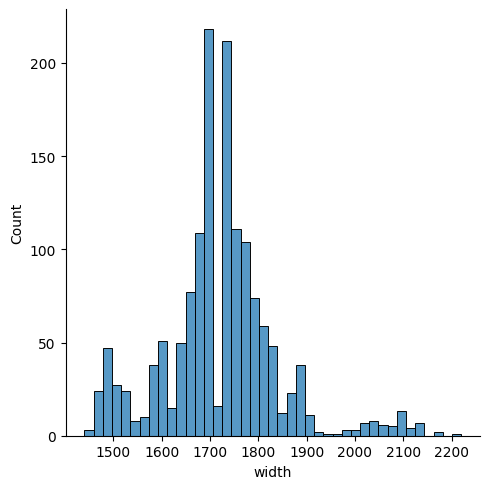

mean: 1720.632472826087 median: 1730.0


In [89]:
sns.displot(df['width'])
plt.show()
print('mean:',df['width'].mean(),'median:',df['width'].median())

In [90]:
df.fillna({'width':df['width'].median()},inplace=True)

In [91]:
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,front_brake_type,gear_box,mileage,wheel_base,height,kerb_weight,length,max_power,max_torque,width
0,Hatchback,1_owner,volkswagen,2022,999 cc,5,R16,Yes,999 CC,Disc,...,solid disc,6 speed,16.0,2470.0,1469.0,1106.0,3971.0,108.0,175.0,1682.0
1,Hatchback,2_owners,hyundai,Oct 2014,814 cc,5,NaN,No,814 CC,Disc,...,solid disc,5 speed,21.0,2380.0,1500.0,880.0,3495.0,55.0,74.0,1550.0
2,SUV,1_owner,hyundai,2023,Manual,5,NaN,No,1197 CC,Disc,...,solid disc,5 speed,20.0,2500.0,1617.0,1106.0,3995.0,82.0,114.0,1770.0
3,Hatchback,1_owner,maruti,Mar 2017,1197 cc,5,16,No,1197 CC,Disc,...,solid disc,5 speed,21.0,2520.0,1510.0,890.0,3995.0,83.0,115.0,1745.0
4,SUV,1_owner,mahindra,2022,Automatic,4,18,Yes,1997 CC,Disc,...,solid disc,6 speed,20.0,2450.0,1844.0,1825.0,3985.0,150.0,320.0,1855.0


### Checking for null values on the newly engineered columns

In [92]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,2,7,0.001349
owner,object,0,3,0.000000
oem,object,0,17,0.000000
Registration Year,object,0,189,0.000000
Engine Displacement,object,3,93,0.002023
Seating Capacity,int64,0,8,0.000000
Alloy Wheel Size,object,570,16,0.384356
Turbo Charger,object,217,6,0.146325
Engine,object,1,97,0.000674
Front Brake Type,object,13,19,0.008766


In [93]:
df.dropna(subset=['front_brake_type','Rear Brake Type','No of Cylinder','Values per Cylinder'],inplace=True)

These two columns namely 'No of Cylinder','Values per Cylinder' has null values ,so I'm dropping the rows considering these two columns as subset in the entire dataframe

In [94]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})


,dtypes,null_count,unique_values,percent_of_null_values
bt,object,2,7,0.001373
owner,object,0,3,0.000000
oem,object,0,16,0.000000
Registration Year,object,0,184,0.000000
Engine Displacement,object,2,89,0.001373
Seating Capacity,int64,0,8,0.000000
Alloy Wheel Size,object,566,16,0.388469
Turbo Charger,object,199,6,0.136582
Engine,object,0,94,0.000000
Front Brake Type,object,0,15,0.000000


In [95]:
new_all_selected_features=['owner', 'oem','body_type', 'registration_year', 
    'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box',
   'Rear Brake Type','seating_capacity','kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base',
   'height', 'kerb_weight', 'length', 'max_power', 'max_torque','width']
for i in car_features:
    new_all_selected_features.append(i)

In [96]:
df=df[new_all_selected_features]
df.head()

,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
0,1_owner,volkswagen,hatchback,2022,r16,yes,solid disc,6 speed,Drum,5,...,2470.0,1469.0,1106.0,3971.0,108.0,175.0,1682.0,5,3.0,4.0
1,2_owners,hyundai,hatchback,2014,r16,no,solid disc,5 speed,Drum,5,...,2380.0,1500.0,880.0,3495.0,55.0,74.0,1550.0,5,3.0,3.0
2,1_owner,hyundai,suv,2023,r16,no,solid disc,5 speed,Drum,5,...,2500.0,1617.0,1106.0,3995.0,82.0,114.0,1770.0,5,4.0,4.0
3,1_owner,maruti,hatchback,2017,r16,no,solid disc,5 speed,Drum,5,...,2520.0,1510.0,890.0,3995.0,83.0,115.0,1745.0,5,4.0,4.0
4,1_owner,mahindra,suv,2022,r18,yes,solid disc,6 speed,Drum,4,...,2450.0,1844.0,1825.0,3985.0,150.0,320.0,1855.0,3,4.0,4.0


In [97]:
#categorical columns list
cc=[]
#numerical columns list
nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        cc.append(i)
    else:
        nc.append(i)
print('categorical_columns:',cc)
print()
print('numerical_columns:',nc)

categorical_columns: ['owner', 'oem', 'body_type', 'registration_year', 'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box', 'Rear Brake Type', 'seating_capacity']

numerical_columns: ['kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base', 'height', 'kerb_weight', 'length', 'max_power', 'max_torque', 'width', 'No Door Numbers', 'No of Cylinder', 'Values per Cylinder']


### Finding outliers in categorical columns and replacing it with upper and lower limit values respectively

In [98]:
def plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

   # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

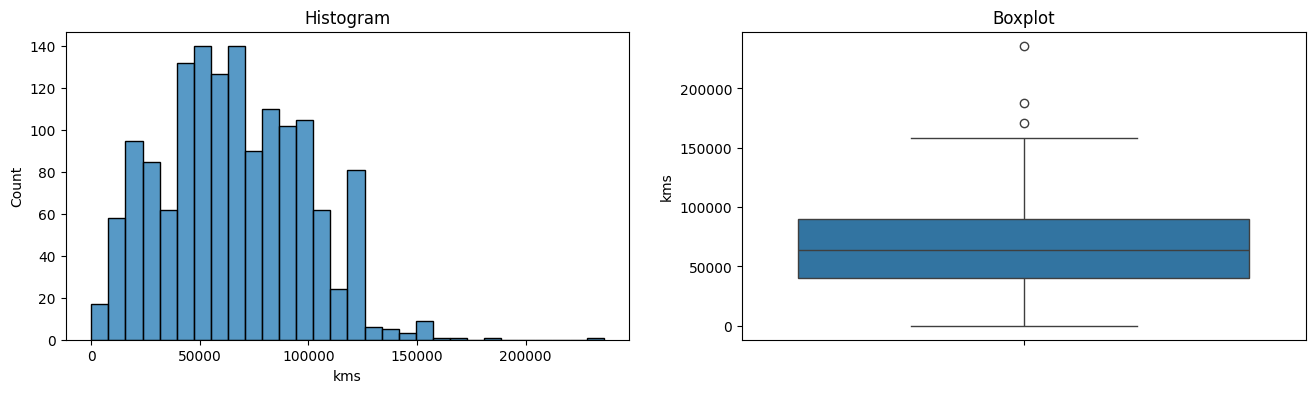

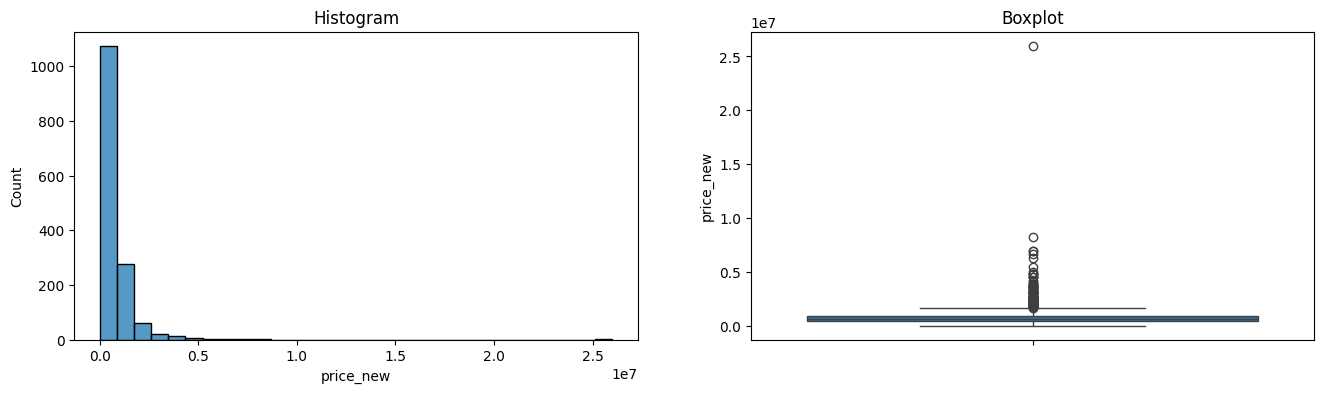

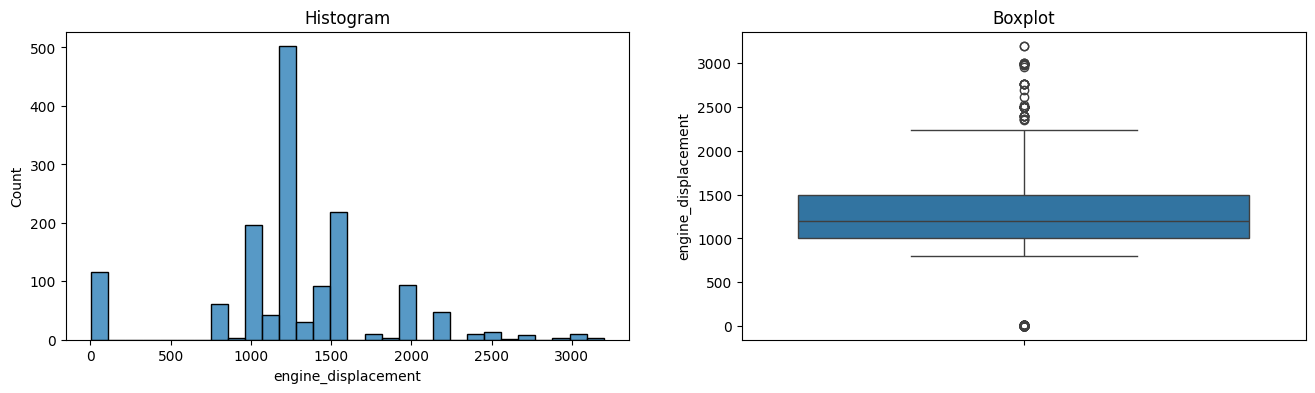

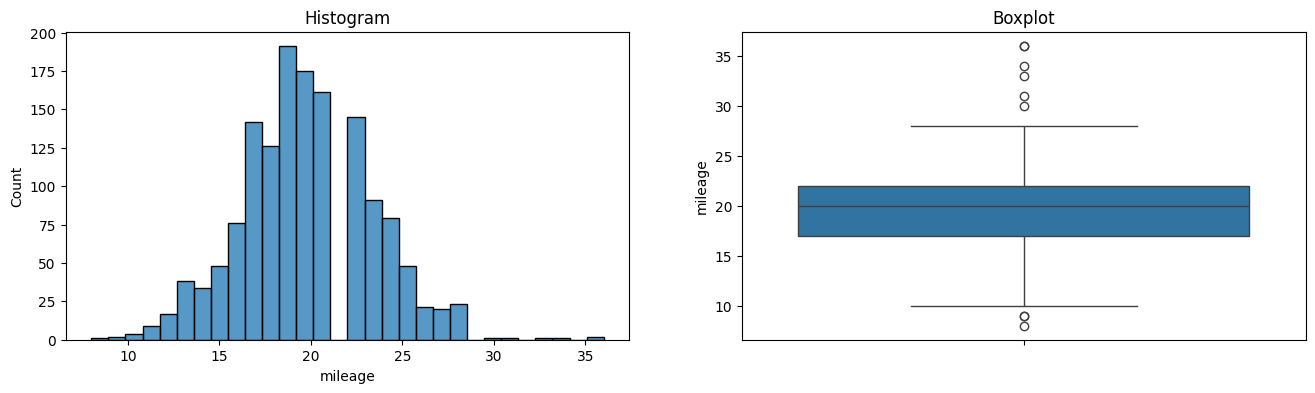

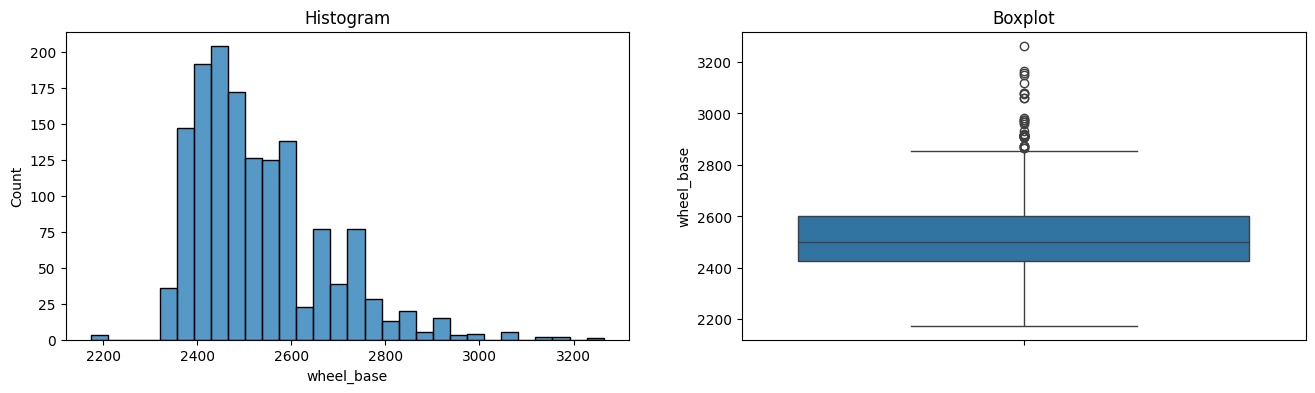

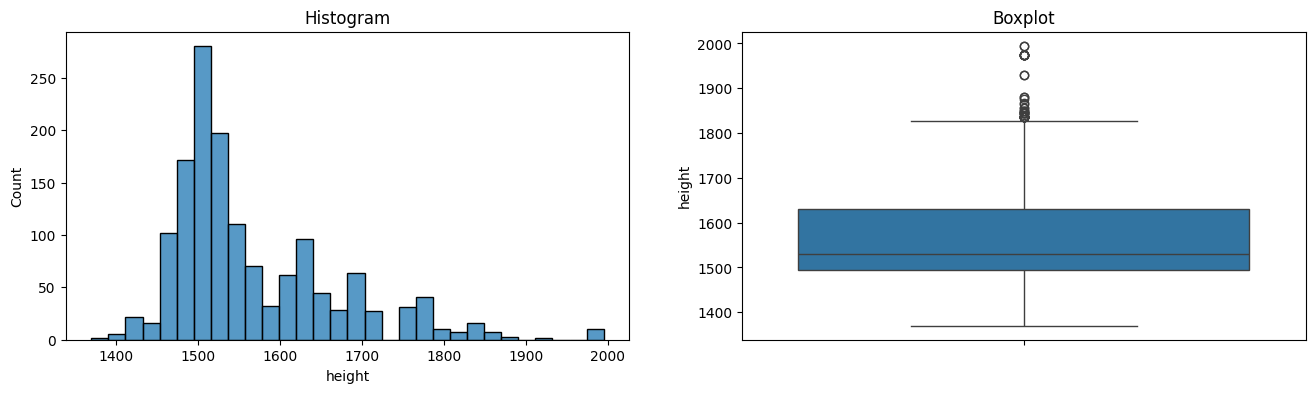

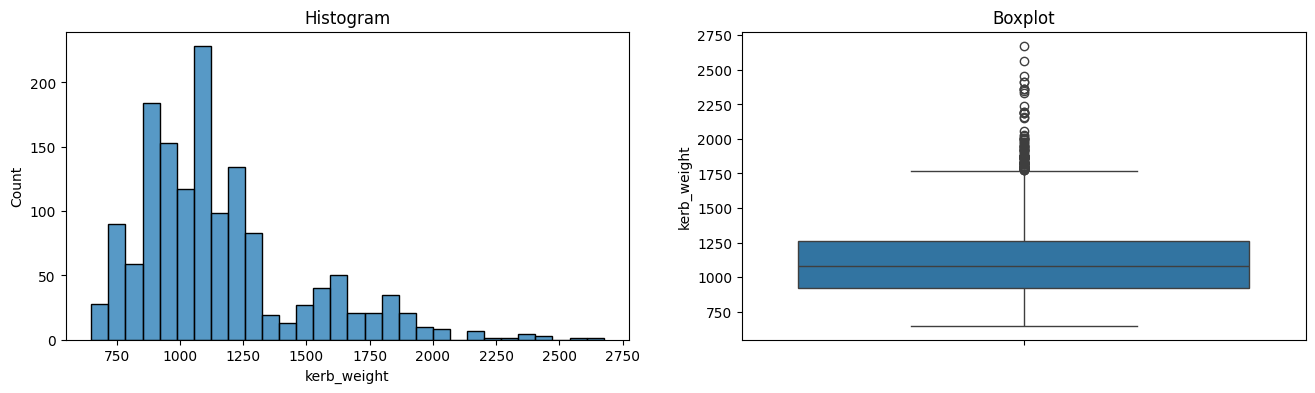

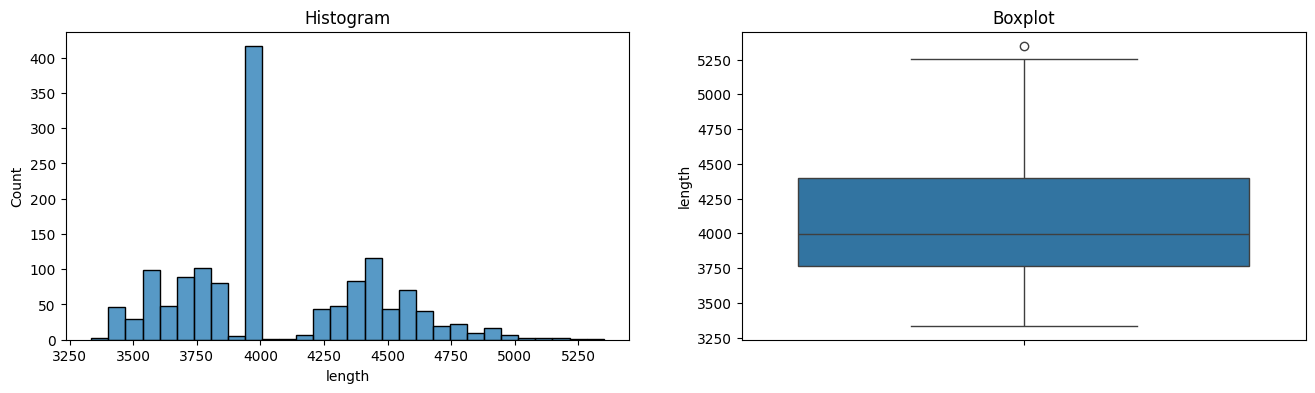

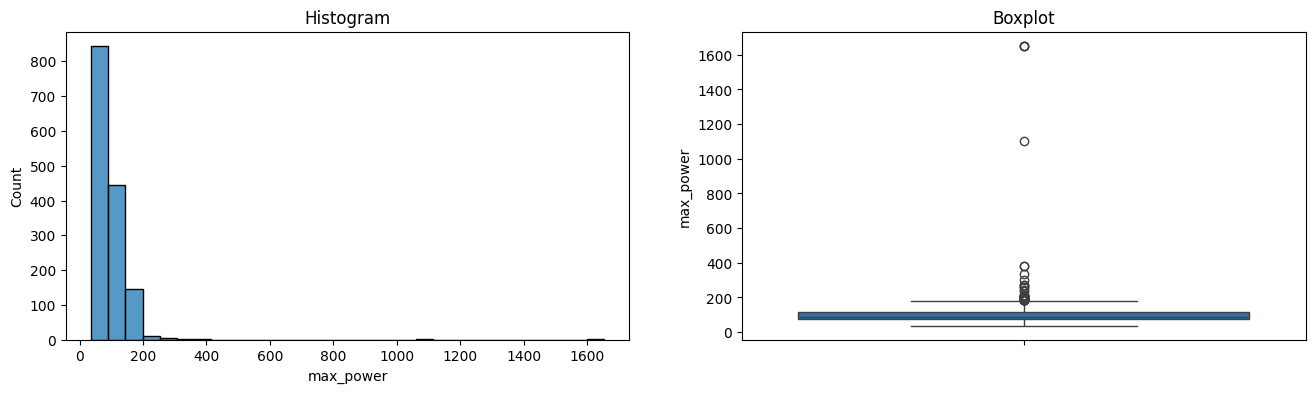

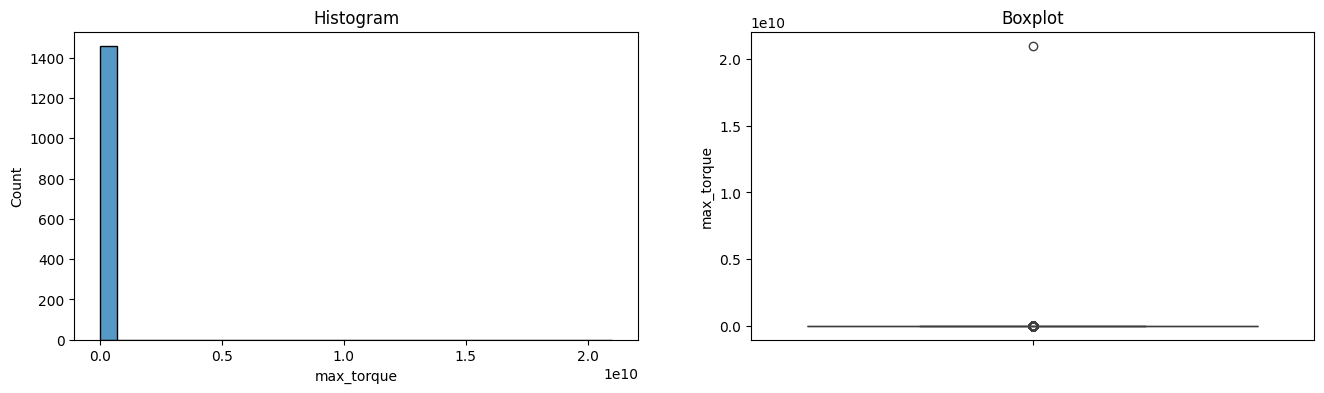

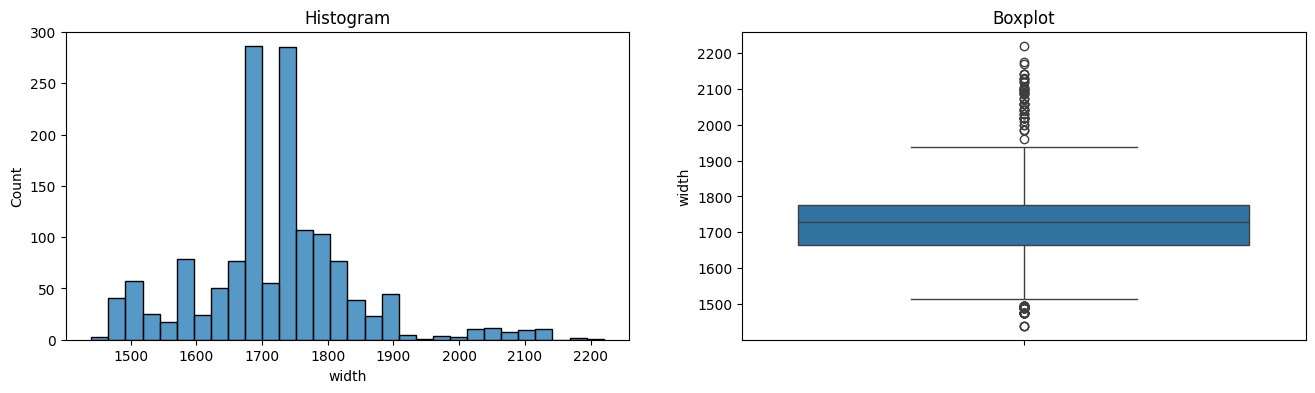

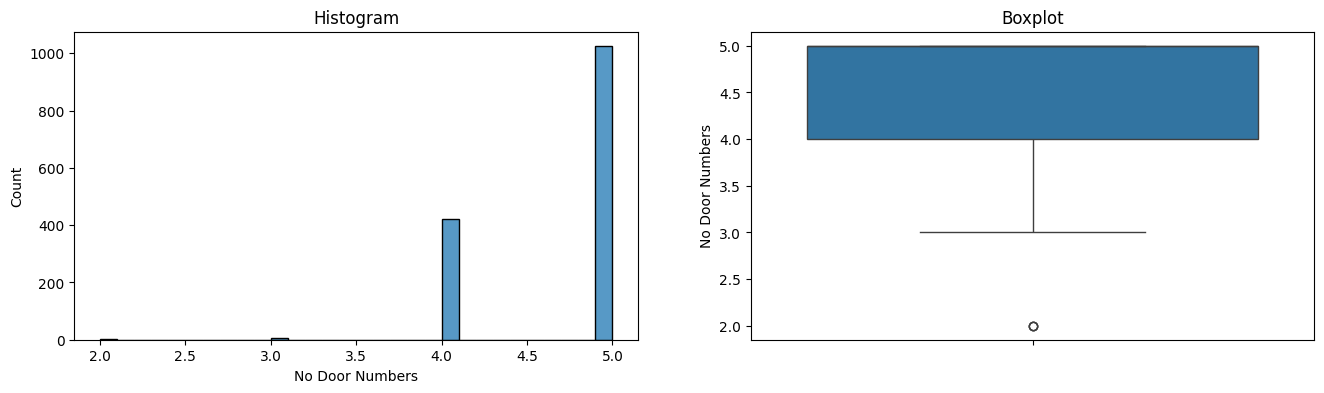

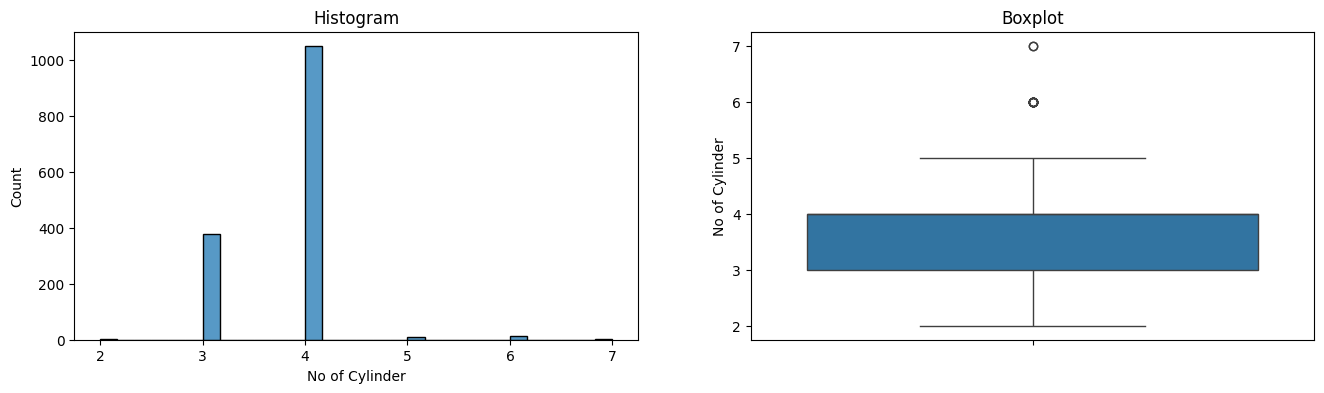

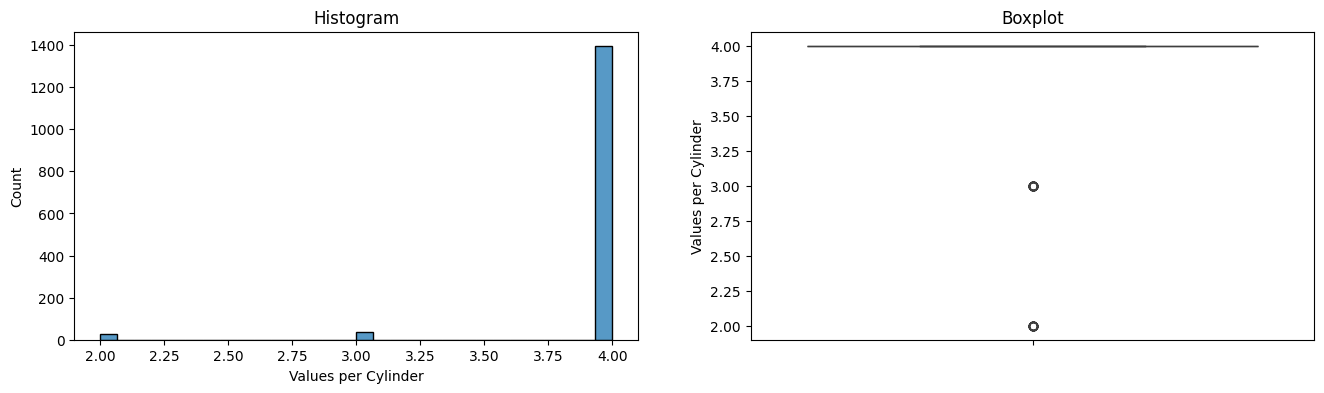

In [99]:
for m in nc:
    plots(df, m)

In [100]:
def find_skewed_boundaries(df, variable, distance):

    # Calculating the boundaries outside which sit the outliers
    # for skewed distributions


    IQR = round(df[variable].quantile(0.75) - df[variable].quantile(0.25))

    lower_boundary = abs(round(df[variable].quantile(0.25) - (IQR * distance)))
    upper_boundary = abs(round(df[variable].quantile(0.75) + (IQR * distance)))

    return upper_boundary, lower_boundary

In [101]:
ul=[]
for v in nc:
    upper_limit, lower_limit = find_skewed_boundaries(df, v, 1.5)
    ul.append((v,upper_limit, lower_limit))

In [102]:
def replace_outlier(dataset,variable,upper_limit,lower_limit):
    dataset[variable]= np.where(dataset[variable] > upper_limit, upper_limit,
                       np.where(dataset[variable] < lower_limit, lower_limit, dataset[variable]))

In [103]:
for v1 in range(len(ul)):
    replace_outlier(df,ul[v1][0],ul[v1][1],ul[v1][2])

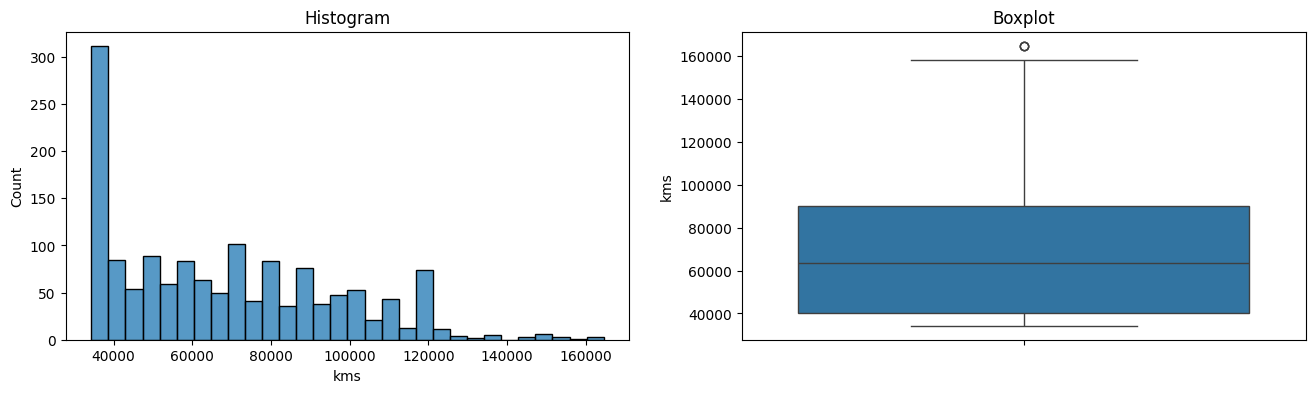

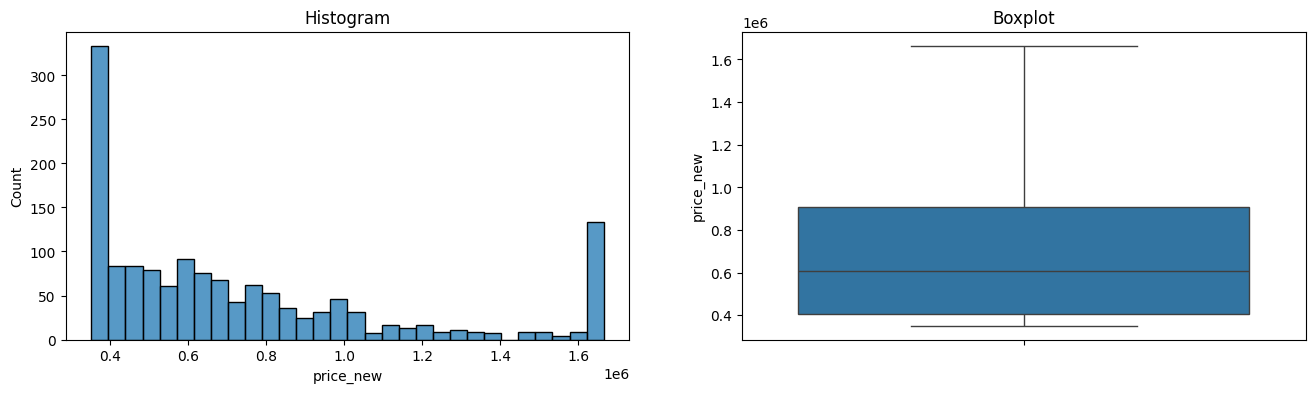

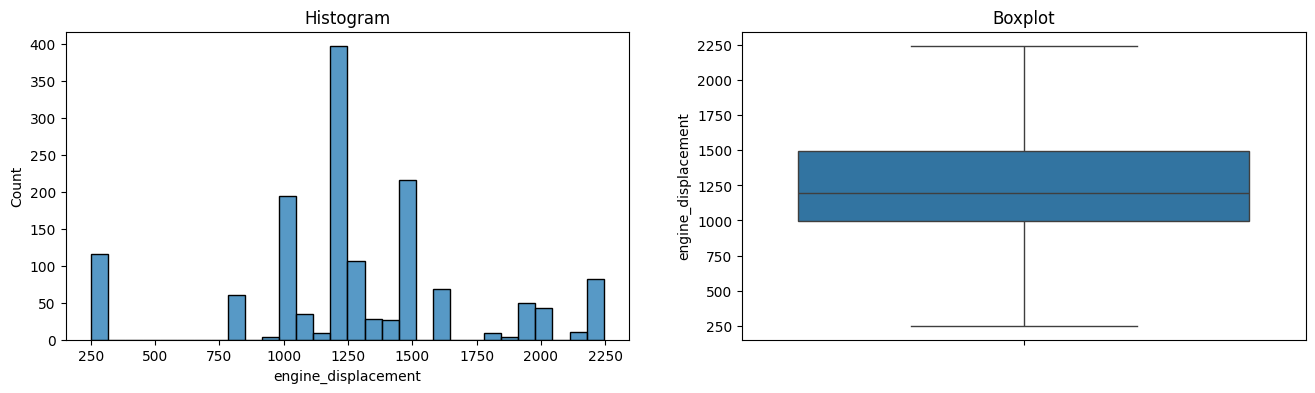

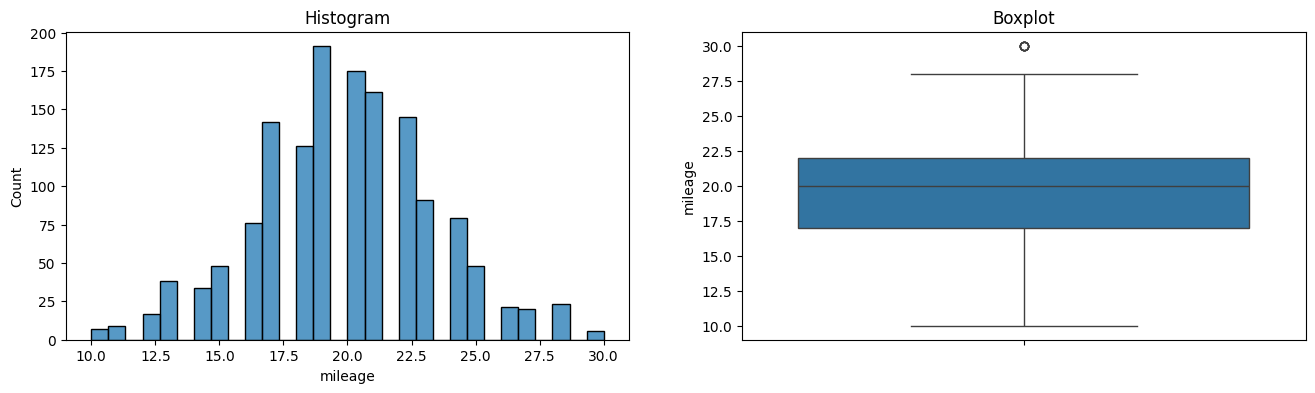

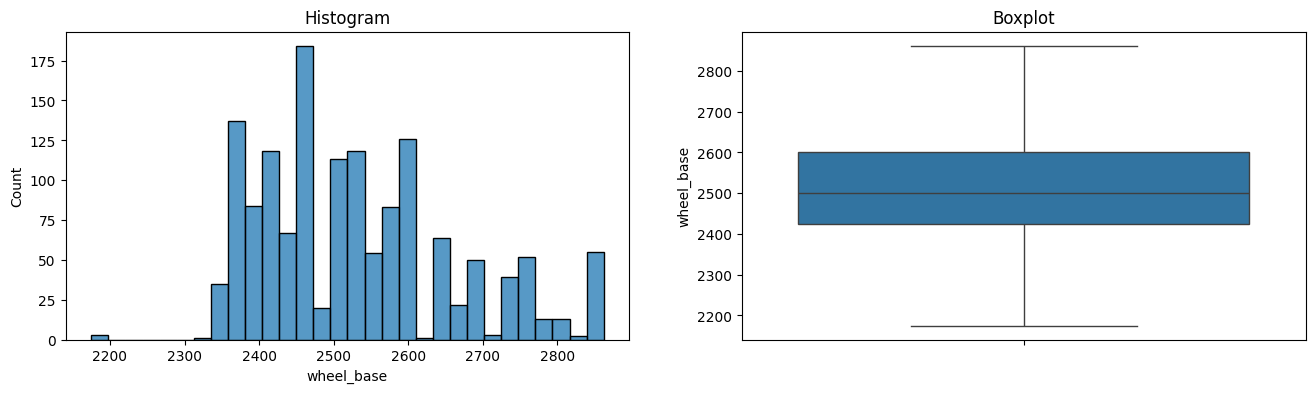

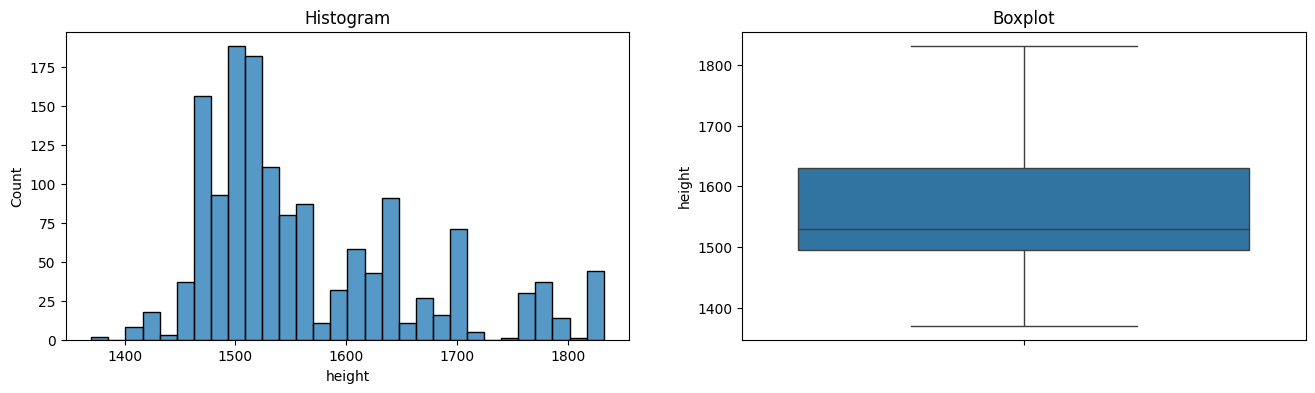

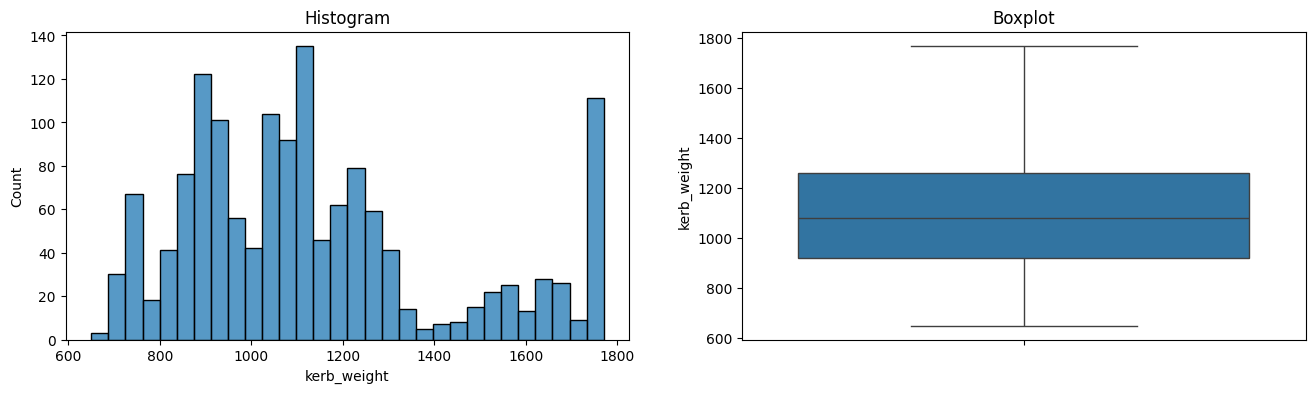

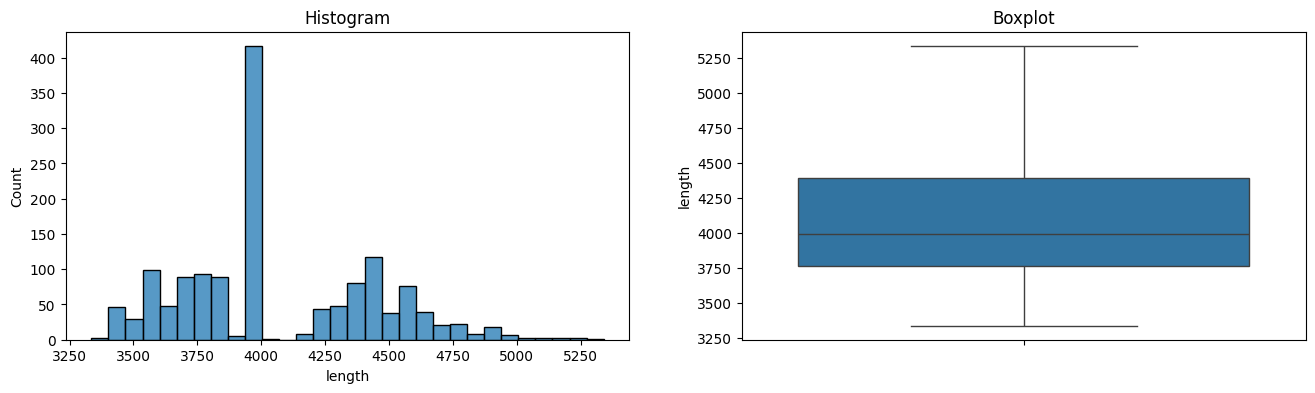

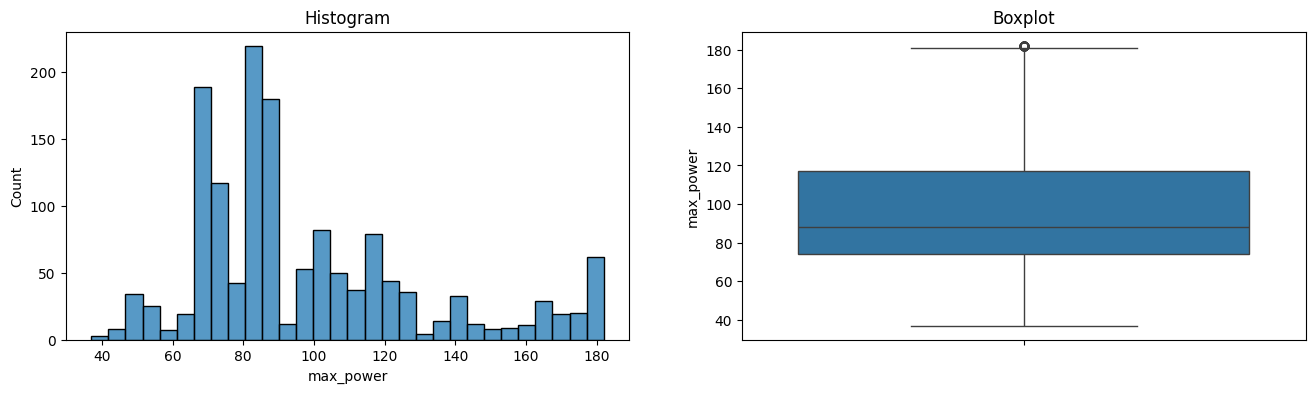

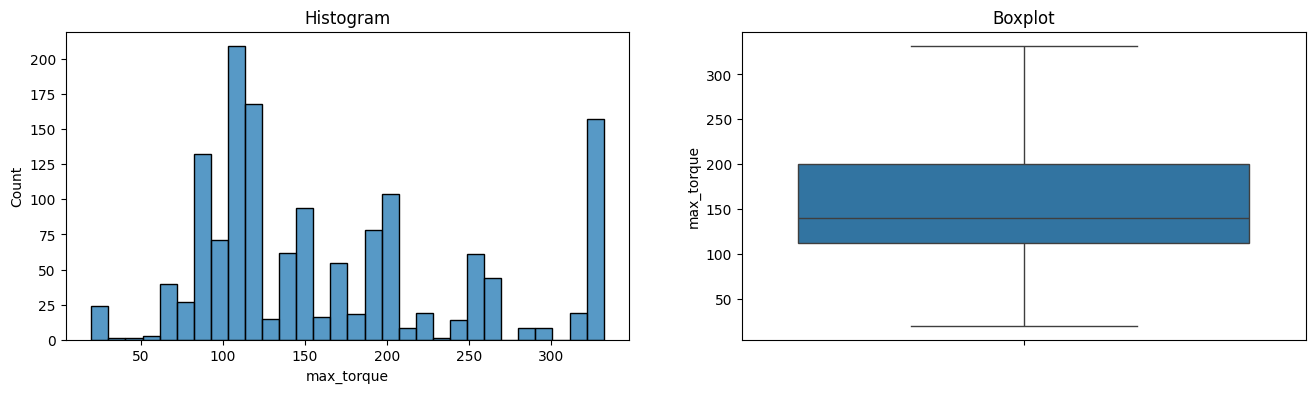

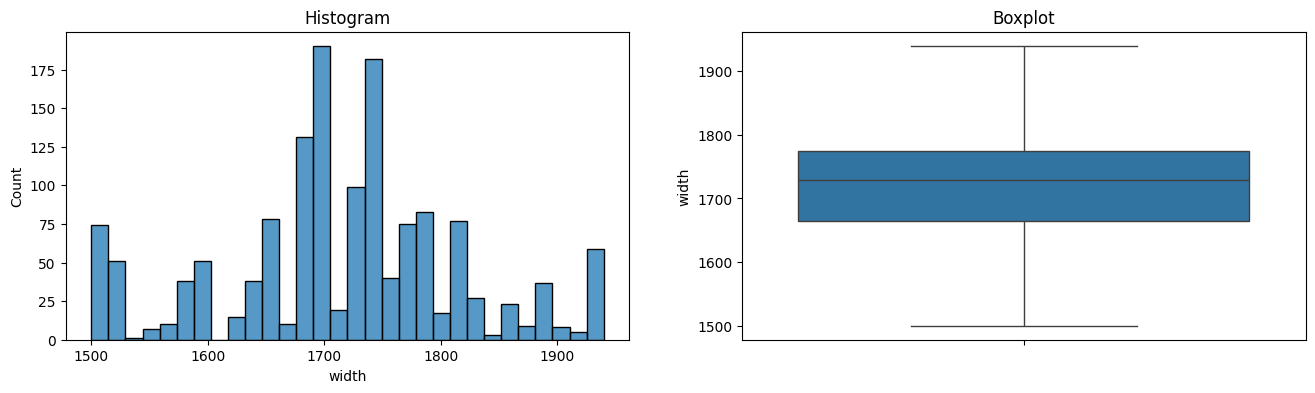

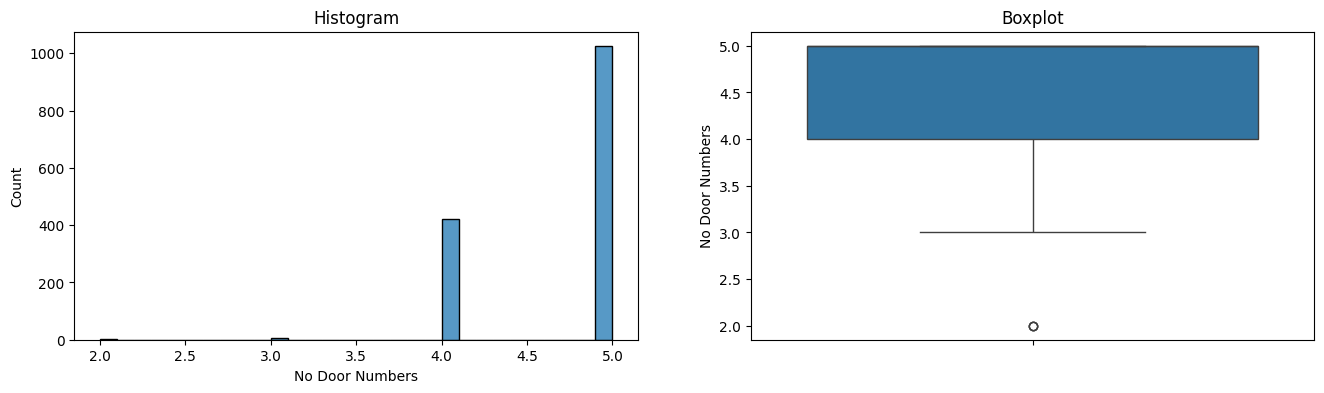

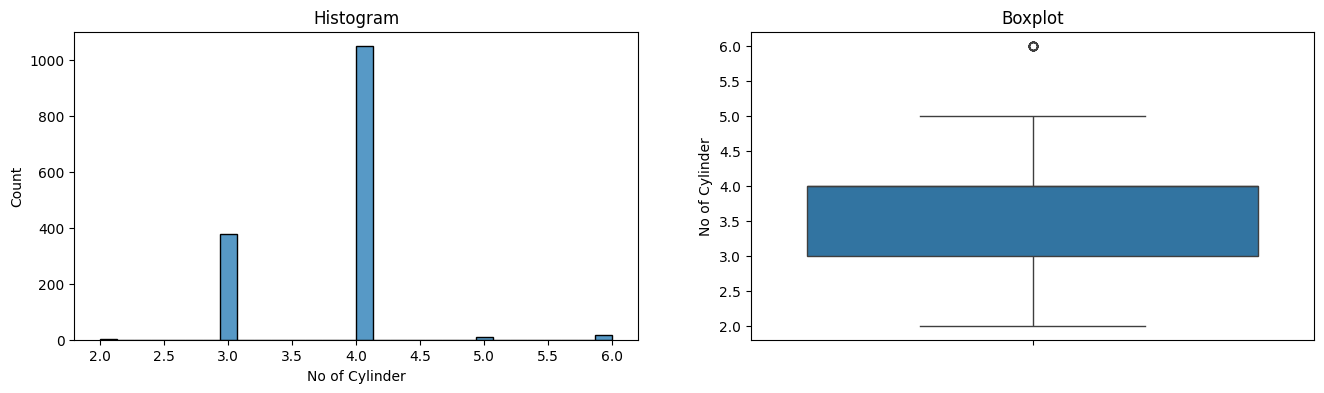

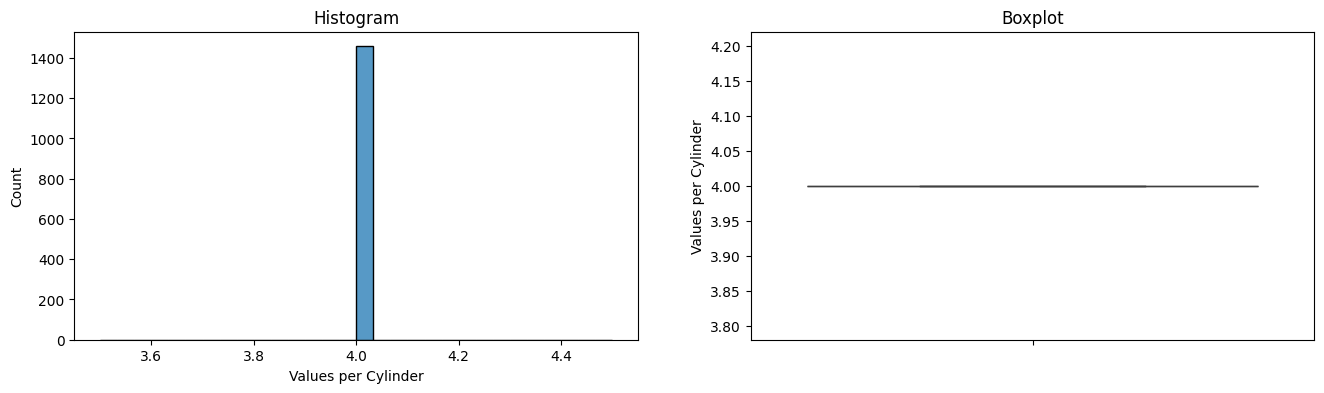

In [104]:
for m in nc:
    plots(df, m)

In [105]:
# for Q-Q plots
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer

def diagnostic_plots(df, variable):

    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable

    plt.figure(figsize=(15, 6))

    # histogram
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.title(f"Histogram of {variable}")

    # q-q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {variable}")

    plt.show()



### Changing the distribution of the 'price_new' and 'kms' columns

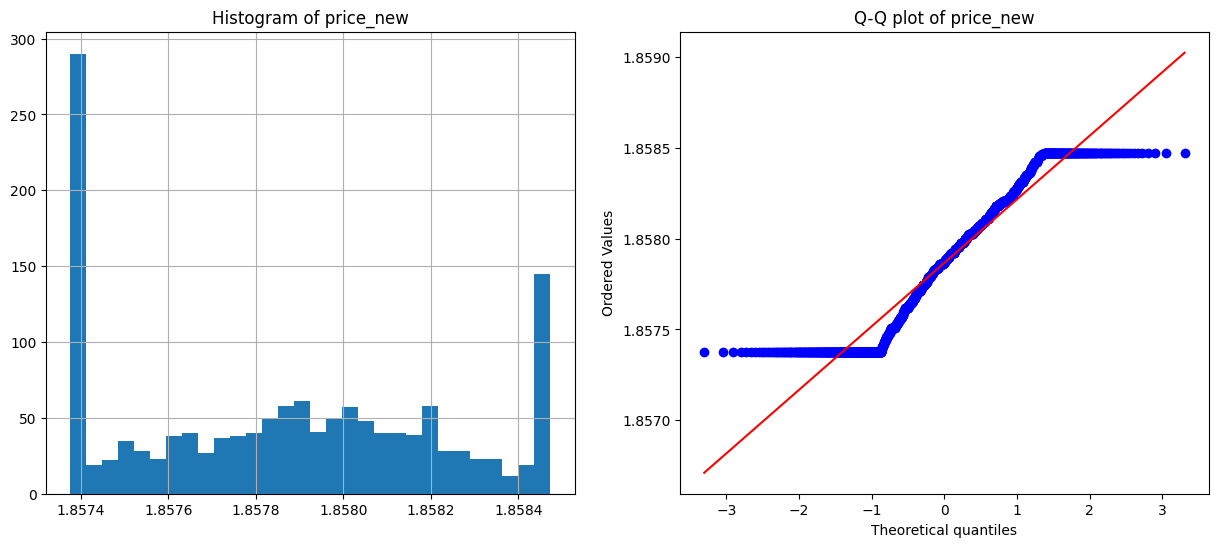

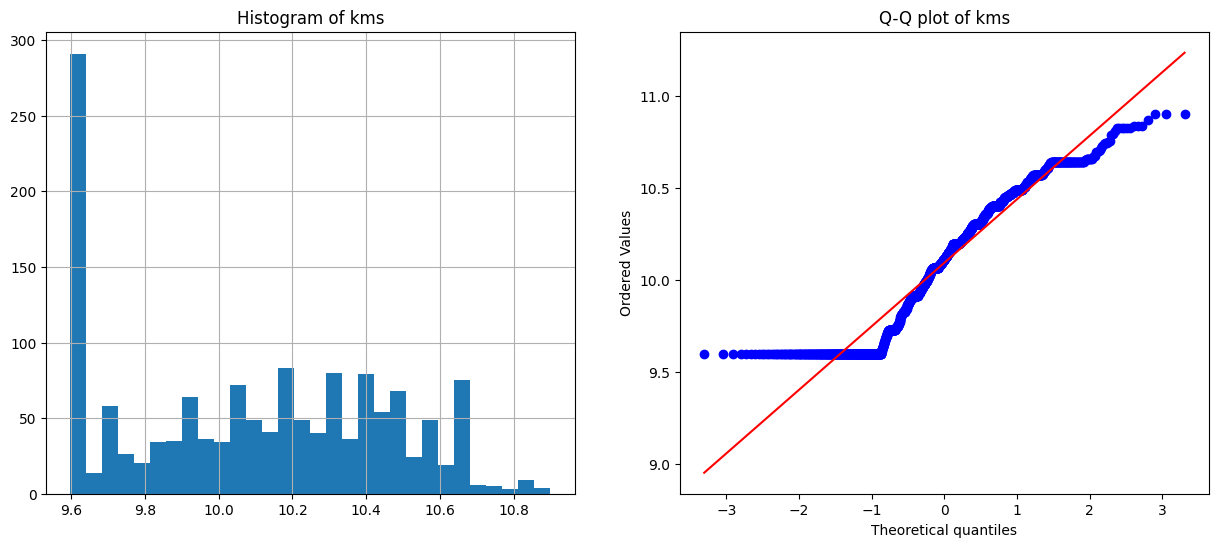

In [106]:
# with open-source packages
from sklearn.preprocessing import PowerTransformer

#transforming the ''price_new' column using "box-cox"
transformer1 = PowerTransformer(method="box-cox", standardize=False)
transformer1.fit(df[['price_new']])
# transformer1.set_output(transform="pandas")
df['price_new']= transformer1.transform(df[['price_new']])

diagnostic_plots(df, 'price_new')

#transforming the 'kms' column using "box-cox"
transformer2 = PowerTransformer(method="box-cox", standardize=False)
transformer2.fit(df[['kms']])
# transformer2.set_output(transform="pandas")
df['kms']= transformer2.transform(df[['kms']])

diagnostic_plots(df, 'kms')

In [107]:
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import MeanEncoder

In [108]:
s=new_all_selected_features.index('price_new')
s1=new_all_selected_features[s]

# Removing the 'price_new' column from 'new_all_selected_features' list
new_all_selected_features.pop(s)
new_all_selected_features

['owner',
 'oem',
 'body_type',
 'registration_year',
 'alloy_wheel_size',
 'turbo_charger',
 'front_brake_type',
 'gear_box',
 'Rear Brake Type',
 'seating_capacity',
 'kms',
 'engine_displacement',
 'mileage',
 'wheel_base',
 'height',
 'kerb_weight',
 'length',
 'max_power',
 'max_torque',
 'width',
 'No Door Numbers',
 'No of Cylinder',
 'Values per Cylinder']

In [109]:
y=df[s1]
X=df[new_all_selected_features]


X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    test_size=0.20,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1165, 23), (292, 23))

In [110]:
mean_enc = MeanEncoder(variables=cc) #cc- categorical columns

In [111]:
mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['owner', 'oem', 'body_type', 'registration_year',
                       'alloy_wheel_size', 'turbo_charger', 'front_brake_type',
                       'gear_box', 'Rear Brake Type', 'seating_capacity'])

In [112]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# let's explore the result
X_train.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) body_type.
  warnings.warn(


,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
1008,1.857934,1.857842,1.857909,1.857594,1.857836,1.857685,1.857898,1.857705,1.857779,1.857838,...,2550.0,1480.0,1100.0,4420.0,116.39,146.0,1695.0,4,4.0,4.0
75,1.857934,1.857815,1.858211,1.858229,1.857837,1.857685,1.857898,1.857705,1.857779,1.857838,...,2500.0,1617.0,1106.0,3995.0,82.00,114.0,1770.0,5,4.0,4.0
395,1.857934,1.857954,1.857909,1.858017,1.857836,1.858084,1.857786,1.858238,1.857779,1.857838,...,2553.0,1467.0,1238.0,4390.0,108.00,250.0,1699.0,4,4.0,4.0
1396,1.857616,1.858102,1.857644,1.857405,1.857377,1.857685,1.857898,1.857705,1.857376,1.857838,...,2345.0,1518.0,840.0,3495.0,62.00,90.0,1500.0,5,4.0,4.0
972,1.857708,1.857954,1.857909,1.857747,1.857836,1.857685,1.857898,1.857705,1.857779,1.857838,...,2552.0,1466.0,1121.0,4384.0,103.00,153.0,1699.0,4,4.0,4.0


In [113]:
X_test.isnull().sum()

owner                  0
oem                    0
body_type              2
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        0
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
dtype: int64

In [114]:
X_test['price_new']=y_test
X_test.dropna(inplace=True)
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        0
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
price_new              0
dtype: int64

In [115]:
y_test=X_test['price_new']
X_test=X_test[new_all_selected_features]
X_test.shape

(290, 23)

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [118]:
# Let's train a linear model.

# Instantiate a linear model.
linreg = LinearRegression()

# Train the model.
linreg.fit(scaler.transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
# print('Train set')
pred_train = linreg.predict(scaler.transform(X_train))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('Linear Regression r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = linreg.predict(scaler.transform(X_test))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('Linear Regression r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Linear Regression rmse: 0.00013425071293074936
Linear Regression r2-score: 0.8657268944821066
Test set
Linear Regression rmse: 0.0001398569533369141
Linear Regression r2-score: 0.8389051333437946



In [119]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [120]:
hr=HistGradientBoostingRegressor(learning_rate=0.05,max_leaf_nodes=300,max_depth=200,
                                               max_iter=1000,
                                               random_state=2023)
# Train the model.
hr.fit(scaler.fit_transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
print('Train set')
pred_train = hr.predict(scaler.transform(X_train))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train)),4))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = hr.predict(scaler.transform(X_test))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Train set
HistGradientBoostingRegressor rmse: 1.3005760147333084e-05
HistGradientBoostingRegressor r2-score: 0.998739835290563
Test set
HistGradientBoostingRegressor rmse: 9.500208014931081e-05
HistGradientBoostingRegressor r2-score: 0.9256673177391271



### Inverse transforming the target column and comparing the 'actual' and 'predicted' values

In [121]:
u1=pd.concat([y_train,y_test],axis=0)
u2=pd.concat([pd.Series(pred_train),pd.Series(pred_test)],axis=0)

pred=transformer1.inverse_transform(pd.DataFrame(u2,columns=['price_new']))
y= transformer1.inverse_transform(u1.values.reshape(-1, 1))
x=pd.DataFrame({'rv':list(y),'pv':list(pred)})
x['residuals']=(x['rv']-x['pv'])
x['error']=(((x['rv']-x['pv']))/(x['rv']))

x['residuals_cor']=[i[0] for i in x['residuals']]
x['error_cor']=[i[0] for i in x['error']]
x.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


,rv,pv,residuals,error,residuals_cor,error_cor
0,[351000.00000000966],[354040.4386049598],[-3040.438604950148],[-0.008662218247720982],-3040.438605,-0.008662
1,[954999.9999998409],[978124.622593852],[-23124.622594011133],[-0.024214264496350772],-23124.622594,-0.024214
2,[944000.0000001317],[943907.5757400423],[92.42426008940674],[9.790705517944264e-05],92.424260,0.000098
3,[351000.00000000966],[346052.34481590416],[4947.655184105504],[0.01409588371539991],4947.655184,0.014096
4,[555999.9999999696],[557159.1025339785],[-1159.1025340089109],[-0.002084716787785925],-1159.102534,-0.002085


In [122]:
x['residuals'].max(),x['residuals'].min()

(array([602579.70375571]), array([-513605.01120619]))

In [123]:
round(list(x['error'].max())[0],2),round(list(x['error'].min())[0],2)

(0.5, -1.25)

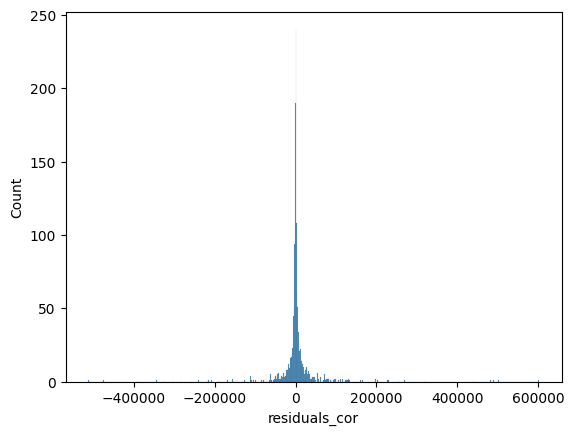

In [124]:
sns.histplot(x['residuals_cor'])
plt.show()

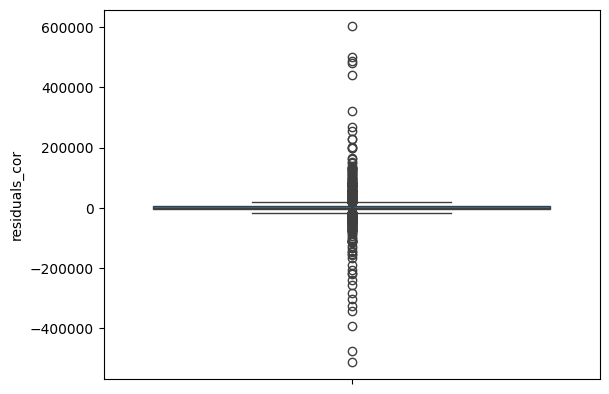

In [125]:
sns.boxplot(x['residuals_cor'])
plt.show()

In [126]:
x['residuals_cor'].describe()

count      1455.000000
mean       1927.687890
std       54470.564510
min     -513605.011206
25%       -3600.867829
50%         126.580023
75%        5160.667308
max      602579.703756
Name: residuals_cor, dtype: float64

### From 248 features ,through various analysis and tests I used only 23 features to predict the 'price' of the cars.Hope the project results are good!!! 